<a href="https://colab.research.google.com/github/nyp-sit/it3103-2024s2/blob/main/week4/yolo8_custom_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using YOLO

Welcome to this week's hands-on lab. In this lab, we are going to learn how to train a balloon detector!

At the end of this exercise, you will be able to:

- create an object detection dataset in YOLO format
- finetune a YOLOv8 pretrained model with the custom dataset
- monitor the training progress and evaluation metrics
- deploy the trained model for object detection

## Create an object detection dataset

We will use a sample balloon dataset to illustrate the process of annotation and packaga the dataset in different format for object detection (e.g. YOLO, Pascal VOC, COCO, etc).

To annotate, there are many different tools available, such as the very basic [LabelImg](https://github.com/HumanSignal/labelImg) , or the more feature-packed tool such as [Label Studio](https://labelstud.io/), or online service such as [Roboflow](https://roboflow.com/).

### Raw Image Dataset

You can download the balloon images (without annotations) from this link:

https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_raw_dataset.zip

Unzip the file to a local folder.

There are total of 74 images. You should divide the images into both training and validation set (e.g. 80%-20%, i.e. 59 images for train, and 15 for test).


### Option 1: Label Studio

You can follow the [steps](https://labelstud.io/guide/quick_start) here to setup Label Studio on your PC. It is recommended to setup a conda environment before you install the Label Studio.  

Here are the steps that need to be done:
1. Create a new Project
2. Import the images into Label Studio
3. Set up the Labelling UI tempalte (choose Object Detection with Bounding Box template)
4. Export the dataset in YOLO format.

The exported dataset will have the following folder structure:
```
<root folder>
classes.txt    --> contains the labels, with each class label on a new line
--images --> contains the images
--labels --> contains the annotations (i.e. bbox coordinates)
notes.json --> some info about this dataset (i.e. not used)
```

For training with Ultralytics, you need to organize the files into train and validate (and optionally test) folders, and to create a data.yaml file to provide information about the folder location of test and validation set:

```
<root folder>
--train
----images
----labels
--valid
----images
----labels
data.yaml
```

The data.yaml file should specify the following:
```
train: ../train/images
val: ../valid/images
test: ../test/images

names:
    0: balloon
```

If you have more than one class of object to detect, specify the rest of the names under the names field.


## Option 2: Roboflow

You can aso create a new account with [Roboflow](https://roboflow.com/). Roboflow integrates very well with Ultralytics and you can easily export the dataset in a format recognized by Ultralytics trainer (for YOLO model)

Similarly, you can create a new account, upload all the raw images, annotate them and then export.

You can choose the format to be YOLOv8 and choose local directory to download the dataset locally instead of pushing it to the Roboflow universal wish.

Here is a [introductory blog](https://blog.roboflow.com/getting-started-with-roboflow/) on using the Roboflow to annotate.





## Auto Labelling using Grounding DINO

Both Label Studio and Roboflow supports the use of Grounding DINO to auto label the dataset.

Grounding DINO is open-set object detector, marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs (prompts) such as category names or referring expressions.

###Label Studio

You can follow the instruction [here](https://labelstud.io/blog/using-text-prompts-for-image-annotation-with-grounding-dino-and-label-studio/)  to setup the Grounding DINO ML backend to integrate with your label studio.

###Roboflow

Here is a [video tutorial](https://youtu.be/SDV6Gz0suAk) on using Grounding DINO with Roboflow.


### Download Annotated Dataset

To save you time for this lab, you can download a pre-annotated balloon dataset [here](https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_annotated_dataset.zip).

We download and unzip to the directory called `datasets`



In [ ]:
%%capture
%%bash
wget https://github.com/CodexSecret/IT3103-Project/raw/main/Yolo8_Crosswalk_Speedlimit_Train.v1i.yolov8.zip
mkdir -p datasets
unzip Yolo8_Crosswalk_Speedlimit_Train.v1i.yolov8.zip -d datasets/

In [ ]:
%%capture
!pip install ultralytics
!pip install comet_ml

## Training the Model

YOLOv8 comes with different sizes of pretrained models: yolov8n, yolov8s, .... The differs in terms of their sizes, inference speeds and precision:

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/yolo-models.png?raw=true" width="70%"/>


We will use the small pretrained model yolo8s and finetune it on our custom dataset.


### Setup the logging

Ultralytics support logging to wandb, comet.ml and tensorboard, out of the box. Here we only enable wandb.

You need to create an account at [wandb](https://wandb.ai) and get the API key from https://wandb.ai/authorize.


In [ ]:
!pip install --upgrade ultralytics

In [ ]:
from ultralytics import settings

settings.update({"wandb": True,
                 "tensorboard": False})

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Training

We specify the path to data.yaml file, and train with a batch size of 15, and we also save the checkpoint at each epoch (save_period=1). We assume here you are connected to a GPU, hence we can specify the device to use as `device=0` to select the first GPU.  We specify the project name as balloon, this will create a folder called `balloon` to store the weights and various training artifacts such as F1, PR curves, confusion matrics, training results (loss, mAP, etc).

For a complete listing of train settings, you can see [here](https://docs.ultralytics.com/modes/train/#train-settings).

You can also specify the type of data [augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters)  you want as part of the train pipeline.

You can monitor your training progress at wandb (the link is given in the train output below)


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/data.yaml",
                     epochs=30,
                     save_period=1,
                     batch=16,
                     device=0,
                     project='roadsigns',
                     plots=True)

100%|██████████| 21.5M/21.5M [00:00<00:00, 172MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=roadsigns, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 75.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 245MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 1517.80it/s]

train: New cache created: /content/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/valid/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1569.85it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to roadsigns/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to roadsigns/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.76G     0.8682      5.256      1.144          3        640: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         24         26      0.113       0.19     0.0519     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.78G     0.9146      3.446      1.193          5        640: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         24         26      0.369      0.669      0.527       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.01G     0.7119      1.676      0.952          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         24         26      0.669       0.82      0.769      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.05G      0.642        1.4     0.9967          7        640: 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         24         26       0.81      0.571      0.693      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.05G     0.7906      1.366      1.102          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         24         26      0.709      0.707      0.783      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.04G     0.7208      1.025      1.039          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         24         26      0.838      0.845      0.874      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.87G     0.7432      1.118      1.042          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         26      0.737      0.788      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.87G     0.7476      1.006      1.033          6        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24         26      0.819      0.547      0.556      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.07G     0.8248      1.104      1.067          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         24         26      0.614      0.446      0.445       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.02G     0.7792     0.8357      1.045          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         24         26      0.203      0.595      0.206      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.87G     0.8102     0.9048      1.081         12        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         24         26      0.434      0.446      0.413      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.02G     0.7627     0.8731      1.057          6        640: 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         24         26      0.707      0.661      0.721      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.86G     0.7181      0.852      1.066          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         24         26      0.716      0.655      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.02G     0.7872      0.835      1.055         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         24         26      0.582      0.649      0.594       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.87G     0.7481     0.7373       1.05         10        640: 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         24         26      0.617      0.515      0.603      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.89G     0.7138     0.7316      1.026          9        640: 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         24         26      0.627      0.497      0.489      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.02G     0.6776     0.7088     0.9807          9        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         24         26      0.717      0.655      0.721      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.88G     0.7142     0.7218     0.9969          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24         26      0.946      0.741      0.804      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.87G      0.723     0.6491      1.013          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         26      0.971      0.767      0.863      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.89G     0.6416     0.5936     0.9948          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         24         26      0.779      0.892      0.897       0.68


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.86G     0.6543     0.6348     0.9821          4        640: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24         26      0.821      0.888      0.915      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.89G     0.6187     0.5896     0.9772          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         24         26      0.949      0.929      0.944       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.02G      0.658     0.5699      1.024          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         26      0.915      0.929      0.937      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.88G     0.6149     0.6897       1.03          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         26          1      0.911      0.942      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.86G     0.6049      0.531     0.9395          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         24         26      0.991      0.887      0.943      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.89G     0.6063      0.475     0.9857          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         24         26      0.996      0.887      0.943      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.86G     0.5408     0.4421     0.9188          4        640: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         24         26      0.978      0.879       0.94      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.89G     0.5841     0.4637     0.9484          5        640: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         24         26      0.895      0.929      0.934      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.86G     0.5333      0.443     0.9176          4        640: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         26      0.961      0.928      0.939      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.89G     0.5007     0.4307      0.921          4        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         24         26       0.97      0.885      0.941      0.778



30 epochs completed in 0.029 hours.
Optimizer stripped from roadsigns/train/weights/last.pt, 22.5MB
Optimizer stripped from roadsigns/train/weights/best.pt, 22.5MB

Validating roadsigns/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


                   all         24         26      0.993      0.887      0.943      0.797
             crosswalk         12         12      0.989      0.917      0.989      0.854
            speedlimit         13         14      0.997      0.857      0.896      0.739
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to roadsigns/train


lr/pg0,▁▂▃▄▄▅▆▆▇▇▇██████▇▇▆▆▅▅▄▄▃▃▂▂▁
lr/pg1,▁▂▃▄▄▅▆▆▇▇▇██████▇▇▆▆▅▅▄▄▃▃▂▂▁
lr/pg2,▁▂▃▄▄▅▆▆▇▇▇██████▇▇▆▆▅▅▄▄▃▃▂▂▁
metrics/mAP50(B),▁▅▇▆▇▇▆▅▄▂▄▆▆▅▅▄▆▇▇███████████
metrics/mAP50-95(B),▁▄▆▆▆▇▅▅▄▂▃▆▅▅▅▄▆▆▇▇▇█████████
metrics/precision(B),▁▃▅▆▆▇▆▇▅▂▄▆▆▅▅▅▆██▆▇█▇████▇██
metrics/recall(B),▁▆▇▅▆▇▇▄▃▅▃▅▅▅▄▄▅▆▆███████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇█▅▃▆▅▅▅▆▆▆▅▅▆▅▅▄▅▅▃▄▃▄▃▃▃▂▂▂▁


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-metrics.png?raw=true"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-loss.png?raw=true"/>

You can go to the folder `balloon-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.88` for `mAP50`, and `0.78` for `mAP50-95`.

In [ ]:
from ultralytics import YOLO

model = YOLO("roadsigns/train/weights/best.pt")
validation_results = model.val(data="datasets/data.yaml", device="0")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


                   all         24         26      0.996      0.887      0.943      0.796
             crosswalk         12         12      0.994      0.917      0.989      0.864
            speedlimit         13         14      0.999      0.857      0.896      0.728
Speed: 0.4ms preprocess, 17.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val


## Export and Deployment

Your model is in pytorch format (.pt). You can export the model to various format, e.g. TorchScript, ONNX, OpenVINO, TensorRT, etc. depending on your use case, and deployment platform (e.g. CPU or GPU, etc)

You can see the list of [supported formats](https://docs.ultralytics.com/modes/export/#export-formats)  and the option they support in terms of further optimization (such as imagesize, int8, half-precision, etc) in the ultralytics site.

Ultralytics provide a utility function to benchmark your model using different supported formats automatically. You can uncomment the code in the following code cell to see the benchmark result. If you are benchmarking for CPU only, the change the `device=0` to `device='cpu'`.  

**Beware: it will take quite a while to complete the benchmark**

In [ ]:
# from ultralytics.utils.benchmarks import benchmark

# # Benchmark on GPU (device=0 means the 1st GPU device)
# benchmark(model="balloon/train/weights/best.pt", data="datasets/data.yaml", imgsz=640, half=False, device=0)


In the following code, we export it as OpenVINO. OpenVINO is optimized for inference on Intel CPUs and since we will use the model later on to do inference on local Windows machine (which runs Intel chip), we will export it as OpenVINO format. We also specify using int8 quantization, which results in faster inference, at the cost of accuracy.

For more information on OpenVINO, go to the [official documentation](https://docs.openvino.ai/2024/index.html).

After export, you can find the openvino model in `balloon\train\weights\best_openvino_model` directory.

In [ ]:
model = YOLO("roadsigns/train/weights/best.pt")
exported_path = model.export(format="openvino", int8=True)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'roadsigns/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)
requirements: Ultralytics requirement ['openvino>=2024.5.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 172.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.7s, installed 1 package: ['openvino>=2024.5.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
requirements: Ultralytics requirement ['nncf>=2.14.0'] not found, attempting AutoUpdate...
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): fi

100%|██████████| 433k/433k [00:00<00:00, 44.5MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 4146.70file/s]

Dataset download success ✅ (1.9s), saved to /content/datasets




Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 4466.78it/s]

New cache created: /content/datasets/coco8/labels/val.cache
OpenVINO: WARNING ⚠️ >300 images recommended for INT8 calibration, found 4 images.


INFO:nncf:16 ignored nodes were found by patterns in the NNCFGraph
INFO:nncf:1 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 161 __module.model.22.dfl/aten::view/Reshape
INFO:nncf:Not adding activation input quantizer for operation: 162 __module.model.22/aten::sigmoid/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 172 __module.model.22.dfl/aten::transpose/Transpose
INFO:nncf:Not adding activation input quantizer for operation: 181 __module.model.22.dfl/aten::softmax/Softmax
INFO:nncf:Not adding activation input quantizer for operation: 190 __module.model.22.dfl.conv/aten::_convolution/Convolution
INFO:nncf:Not adding activation input quantizer for operation: 197 __module.model.22.dfl/aten::view/Reshape_1
INFO:nncf:Not adding activation input quantizer for operation: 209 __module.model.22/aten::sub/Subtract
INFO:nncf:Not adding activation input quantizer for operation: 210 __module.model.22/aten:

Output()

Output()

OpenVINO: export success ✅ 42.8s, saved as 'roadsigns/train/weights/best_int8_openvino_model/' (11.2 MB)

Export complete (45.2s)
Results saved to /content/roadsigns/train/weights
Predict:         yolo predict task=detect model=roadsigns/train/weights/best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=roadsigns/train/weights/best_int8_openvino_model imgsz=640 data=datasets/data.yaml int8 
Visualize:       https://netron.app


## Inference

Let's test our model on some sample pictures. You can optionally specify the confidence threshold (e.g. `conf=0.5`), and the IoU (e.g. `iou=0.6`) for the NMS. The model will only output the bounding boxes of those detection that exceeds the confidence threshould and the IoU threshold.  

Loading roadsigns/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...



100%|██████████| 60.5k/60.5k [00:00<00:00, 51.5MB/s]


image 1/1 /content/german-pedestrian-crossing-sign.jpg: 640x640 1 crosswalk, 337.4ms
Speed: 13.7ms preprocess, 337.4ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'crosswalk', 1: 'speedlimit'}
obb: None
orig_img: array([[[168, 145, 130],
        [168, 145, 130],
        [169, 146, 131],
        ...,
        [198, 201, 205],
        [198, 201, 205],
        [199, 202, 206]],

       [[168, 145, 130],
        [168, 145, 130],
        [169, 146, 131],
        ...,
        [199, 202, 206],
        [201, 204, 208],
        [202, 205, 209]],

       [[168, 145, 130],
        [169, 146, 131],
        [170, 147, 132],
        ...,
        [201, 204, 209],
        [203, 206, 211],
        [206, 209, 214]],

       ...,

       [[ 17,  15,   7],
        [ 11,   9,   1],
        [  6,   3,   0],
        ...,
        [ 10,  12,  12]

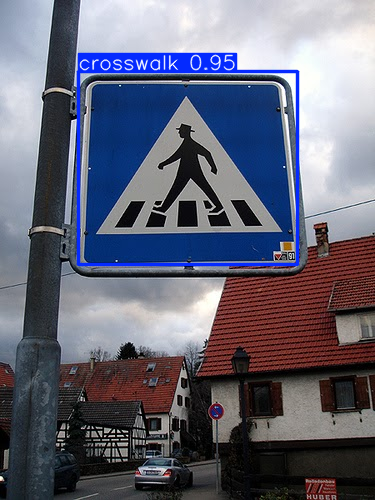

In [ ]:
import ultralytics
from ultralytics import YOLO
from PIL import Image

source = 'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiEkaY0tRyfq22SsAB4tFLAPO76raN219HU6EplXHtxxQaWszoVvss7OQ75jopp15Mgx8mkBGLkGaQTBw4S9AefCr9BKxiLN_n-U1vdSlfTx3YU0gvXwBjT2kBPM-XlW4pNS_0UzAZWxY8/w1200-h630-p-k-no-nu/german-pedestrian-crossing-sign.jpg'
#source = './samples/sample_balloon.jpeg'
model = YOLO("roadsigns/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

## Streaming

We can also do real-time detection on a video or camera steram.

The code below uses openCV library to display video in a window, and can only be run locally on a local laptop.

If you are training your model on Google Colab, you will download the exported OpenVINO model to a local PC. If you are training your model locally, then the exported model should already be on your local PC.

Run the following code to zip up the OpenVINO folder and download to local PC.


*Note: If you encountered error message "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968", uncomment the following cell and run it.*


In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%bash
mv ./roadsigns/train/weights/best_int8_openvino_model/ .
zip -r best_int8_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

  adding: best_int8_openvino_model/ (stored 0%)
  adding: best_int8_openvino_model/best.xml (deflated 95%)
  adding: best_int8_openvino_model/best.bin (deflated 17%)
  adding: best_int8_openvino_model/metadata.yaml (deflated 32%)


### Video File

You need openCV to run the following code.  In your conda environment, install opencv for python using the following command:

```
pip3 install opencv-python
```
or
```
conda install opencv
```

Let's donwload the sample video file.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!wget 'https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/PkCzQ9J/videoblocks-mountain-road-with-road-signs_hgvm6xzwb__fb7ababb5490fd1b447129e8e5e9b697__P360.mp4'

--2024-12-26 14:14:32--  https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/PkCzQ9J/videoblocks-mountain-road-with-road-signs_hgvm6xzwb__fb7ababb5490fd1b447129e8e5e9b697__P360.mp4
Resolving dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)... 108.158.4.44, 108.158.4.67, 108.158.4.77, ...
Connecting to dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)|108.158.4.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2823640 (2.7M) [video/mp4]
Saving to: ‘videoblocks-mountain-road-with-road-signs_hgvm6xzwb__fb7ababb5490fd1b447129e8e5e9b697__P360.mp4’

videoblocks-mountai 100%[===================>]   2.69M  --.-KB/s    in 0.02s   

2024-12-26 14:14:32 (176 MB/s) - ‘videoblocks-mountain-road-with-road-signs_hgvm6xzwb__fb7ababb5490fd1b447129e8e5e9b697__P360.mp4’ saved [2823640/2823640]



### Streaming and display video

In [ ]:
from ultralytics import YOLO
import cv2

# Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# Open the video file
video_path = "balloon.mp4"
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame on GPU Device 0
        results = model(frame, device="cpu")

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

### Detect and write to a video file

In [ ]:
from ultralytics import YOLO
import cv2
from tqdm import tqdm

def write_video(video_in_filepath, video_out_filepath, model):
    # Open the video file

    video_reader = cv2.VideoCapture(video_in_filepath)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    video_writer = cv2.VideoWriter(video_out_filepath,
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps,
                            (frame_w, frame_h))

    # Loop through the video frames
    for i in tqdm(range(nb_frames)):
        # Read a frame from the video
        success, frame = video_reader.read()

        if success:
            # Run YOLO inference on the frame on GPU Device 0
            results = model(frame, device=0)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Write the annotated frame
            video_writer.write(annotated_frame)

    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


In [ ]:
from pathlib import Path
import os

video_in_file = "videoblocks-mountain-road-with-road-signs_hgvm6xzwb__fb7ababb5490fd1b447129e8e5e9b697__P360.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected' + '.mp4')
model = YOLO("best_int8_openvino_model", task="detect")
write_video(video_in_file, video_out_file, model)

  0%|          | 0/574 [00:00<?, ?it/s]

Loading best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

0: 640x640 (no detections), 322.5ms
Speed: 5.8ms preprocess, 322.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/574 [00:01<10:48,  1.13s/it]


0: 640x640 (no detections), 289.6ms
Speed: 9.5ms preprocess, 289.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 2/574 [00:01<06:14,  1.53it/s]


0: 640x640 (no detections), 316.3ms
Speed: 7.4ms preprocess, 316.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 3/574 [00:01<04:52,  1.95it/s]


0: 640x640 (no detections), 335.2ms
Speed: 4.5ms preprocess, 335.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 4/574 [00:02<04:19,  2.20it/s]


0: 640x640 (no detections), 327.7ms
Speed: 10.2ms preprocess, 327.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 5/574 [00:02<03:57,  2.39it/s]


0: 640x640 (no detections), 318.0ms
Speed: 4.9ms preprocess, 318.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 6/574 [00:02<03:41,  2.56it/s]


0: 640x640 (no detections), 424.8ms
Speed: 5.6ms preprocess, 424.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 7/574 [00:03<03:53,  2.43it/s]


0: 640x640 (no detections), 292.3ms
Speed: 6.6ms preprocess, 292.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 8/574 [00:03<03:37,  2.60it/s]


0: 640x640 (no detections), 307.7ms
Speed: 3.0ms preprocess, 307.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 9/574 [00:03<03:29,  2.70it/s]


0: 640x640 (no detections), 293.6ms
Speed: 5.0ms preprocess, 293.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 10/574 [00:04<03:20,  2.81it/s]


0: 640x640 (no detections), 542.6ms
Speed: 3.3ms preprocess, 542.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 11/574 [00:04<04:04,  2.30it/s]


0: 640x640 (no detections), 600.7ms
Speed: 10.1ms preprocess, 600.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 12/574 [00:05<04:42,  1.99it/s]


0: 640x640 (no detections), 557.8ms
Speed: 22.0ms preprocess, 557.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 13/574 [00:06<04:59,  1.87it/s]


0: 640x640 (no detections), 596.5ms
Speed: 3.8ms preprocess, 596.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 14/574 [00:06<05:14,  1.78it/s]


0: 640x640 (no detections), 363.1ms
Speed: 3.3ms preprocess, 363.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 15/574 [00:07<04:45,  1.96it/s]


0: 640x640 (no detections), 454.8ms
Speed: 3.0ms preprocess, 454.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 16/574 [00:07<04:40,  1.99it/s]


0: 640x640 (no detections), 718.3ms
Speed: 3.1ms preprocess, 718.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 17/574 [00:08<05:20,  1.74it/s]


0: 640x640 (no detections), 601.0ms
Speed: 2.9ms preprocess, 601.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 18/574 [00:09<05:30,  1.68it/s]


0: 640x640 (no detections), 785.7ms
Speed: 11.6ms preprocess, 785.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 19/574 [00:09<06:09,  1.50it/s]


0: 640x640 (no detections), 614.9ms
Speed: 3.0ms preprocess, 614.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 20/574 [00:10<06:05,  1.52it/s]


0: 640x640 (no detections), 947.7ms
Speed: 3.1ms preprocess, 947.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 21/574 [00:11<06:57,  1.33it/s]


0: 640x640 (no detections), 947.1ms
Speed: 11.1ms preprocess, 947.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 22/574 [00:12<07:35,  1.21it/s]


0: 640x640 (no detections), 929.2ms
Speed: 5.7ms preprocess, 929.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 23/574 [00:13<07:57,  1.15it/s]


0: 640x640 (no detections), 863.5ms
Speed: 8.7ms preprocess, 863.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 24/574 [00:14<08:01,  1.14it/s]


0: 640x640 (no detections), 849.8ms
Speed: 6.3ms preprocess, 849.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 25/574 [00:15<08:02,  1.14it/s]


0: 640x640 (no detections), 262.4ms
Speed: 6.7ms preprocess, 262.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 26/574 [00:15<06:25,  1.42it/s]


0: 640x640 (no detections), 236.4ms
Speed: 6.1ms preprocess, 236.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 27/574 [00:15<05:11,  1.76it/s]


0: 640x640 (no detections), 180.7ms
Speed: 3.5ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 28/574 [00:15<04:10,  2.18it/s]


0: 640x640 (no detections), 196.1ms
Speed: 3.1ms preprocess, 196.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 29/574 [00:16<03:29,  2.60it/s]


0: 640x640 (no detections), 173.8ms
Speed: 3.2ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 30/574 [00:16<02:57,  3.07it/s]


0: 640x640 (no detections), 175.1ms
Speed: 3.4ms preprocess, 175.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 31/574 [00:16<02:35,  3.50it/s]


0: 640x640 (no detections), 180.1ms
Speed: 3.6ms preprocess, 180.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 32/574 [00:16<02:20,  3.87it/s]


0: 640x640 (no detections), 179.6ms
Speed: 4.5ms preprocess, 179.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 33/574 [00:16<02:09,  4.16it/s]


0: 640x640 (no detections), 205.8ms
Speed: 3.9ms preprocess, 205.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 34/574 [00:17<02:06,  4.25it/s]


0: 640x640 (no detections), 205.0ms
Speed: 4.4ms preprocess, 205.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 35/574 [00:17<02:04,  4.31it/s]


0: 640x640 (no detections), 177.5ms
Speed: 4.3ms preprocess, 177.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 36/574 [00:17<01:58,  4.53it/s]


0: 640x640 (no detections), 182.1ms
Speed: 4.2ms preprocess, 182.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 37/574 [00:17<01:54,  4.67it/s]


0: 640x640 (no detections), 209.4ms
Speed: 3.6ms preprocess, 209.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 38/574 [00:18<01:56,  4.59it/s]


0: 640x640 (no detections), 193.4ms
Speed: 3.8ms preprocess, 193.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 39/574 [00:18<01:55,  4.64it/s]


0: 640x640 (no detections), 186.9ms
Speed: 2.9ms preprocess, 186.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 40/574 [00:18<01:53,  4.72it/s]


0: 640x640 (no detections), 176.2ms
Speed: 2.9ms preprocess, 176.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 41/574 [00:18<01:49,  4.85it/s]


0: 640x640 (no detections), 250.7ms
Speed: 4.0ms preprocess, 250.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 42/574 [00:18<01:59,  4.46it/s]


0: 640x640 (no detections), 269.1ms
Speed: 3.1ms preprocess, 269.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 43/574 [00:19<02:09,  4.11it/s]


0: 640x640 (no detections), 255.0ms
Speed: 3.0ms preprocess, 255.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 44/574 [00:19<02:14,  3.94it/s]


0: 640x640 (no detections), 243.0ms
Speed: 3.0ms preprocess, 243.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 45/574 [00:19<02:15,  3.89it/s]


0: 640x640 (no detections), 185.1ms
Speed: 3.6ms preprocess, 185.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 46/574 [00:19<02:07,  4.14it/s]


0: 640x640 (no detections), 178.7ms
Speed: 4.4ms preprocess, 178.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 47/574 [00:20<02:00,  4.38it/s]


0: 640x640 (no detections), 182.3ms
Speed: 3.0ms preprocess, 182.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 48/574 [00:20<01:55,  4.54it/s]


0: 640x640 1 crosswalk, 167.1ms
Speed: 4.1ms preprocess, 167.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 49/574 [00:20<01:50,  4.76it/s]


0: 640x640 1 crosswalk, 177.4ms
Speed: 3.8ms preprocess, 177.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 50/574 [00:20<01:47,  4.86it/s]


0: 640x640 1 crosswalk, 176.2ms
Speed: 2.8ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 51/574 [00:20<01:45,  4.94it/s]


0: 640x640 2 crosswalks, 187.3ms
Speed: 3.0ms preprocess, 187.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 52/574 [00:21<01:46,  4.90it/s]


0: 640x640 1 crosswalk, 187.5ms
Speed: 4.2ms preprocess, 187.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 53/574 [00:21<01:46,  4.89it/s]


0: 640x640 1 crosswalk, 170.9ms
Speed: 3.8ms preprocess, 170.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 54/574 [00:21<01:43,  5.01it/s]


0: 640x640 2 crosswalks, 179.8ms
Speed: 3.0ms preprocess, 179.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 55/574 [00:21<01:43,  5.01it/s]


0: 640x640 1 crosswalk, 174.2ms
Speed: 4.8ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 56/574 [00:21<01:42,  5.06it/s]


0: 640x640 1 crosswalk, 196.3ms
Speed: 5.5ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 57/574 [00:22<01:45,  4.92it/s]


0: 640x640 1 crosswalk, 196.4ms
Speed: 3.1ms preprocess, 196.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 58/574 [00:22<01:46,  4.85it/s]


0: 640x640 (no detections), 175.9ms
Speed: 4.0ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 59/574 [00:22<01:44,  4.91it/s]


0: 640x640 (no detections), 178.7ms
Speed: 3.7ms preprocess, 178.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 60/574 [00:22<01:43,  4.95it/s]


0: 640x640 (no detections), 175.2ms
Speed: 3.5ms preprocess, 175.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 61/574 [00:22<01:42,  5.00it/s]


0: 640x640 (no detections), 194.4ms
Speed: 4.5ms preprocess, 194.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 62/574 [00:23<01:44,  4.90it/s]


0: 640x640 (no detections), 194.0ms
Speed: 3.7ms preprocess, 194.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 63/574 [00:23<01:45,  4.85it/s]


0: 640x640 (no detections), 186.0ms
Speed: 3.0ms preprocess, 186.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 64/574 [00:23<01:44,  4.88it/s]


0: 640x640 (no detections), 180.9ms
Speed: 3.1ms preprocess, 180.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 65/574 [00:23<01:43,  4.94it/s]


0: 640x640 (no detections), 184.7ms
Speed: 3.7ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 66/574 [00:23<01:43,  4.93it/s]


0: 640x640 (no detections), 183.2ms
Speed: 3.0ms preprocess, 183.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 67/574 [00:24<01:42,  4.93it/s]


0: 640x640 (no detections), 180.5ms
Speed: 3.3ms preprocess, 180.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 68/574 [00:24<01:41,  4.97it/s]


0: 640x640 (no detections), 169.5ms
Speed: 3.1ms preprocess, 169.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 69/574 [00:24<01:39,  5.10it/s]


0: 640x640 (no detections), 173.6ms
Speed: 3.1ms preprocess, 173.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 70/574 [00:24<01:37,  5.15it/s]


0: 640x640 (no detections), 176.1ms
Speed: 4.2ms preprocess, 176.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 71/574 [00:24<01:37,  5.14it/s]


0: 640x640 (no detections), 192.8ms
Speed: 3.1ms preprocess, 192.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 72/574 [00:25<01:40,  5.01it/s]


0: 640x640 (no detections), 198.3ms
Speed: 3.1ms preprocess, 198.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 73/574 [00:25<01:42,  4.90it/s]


0: 640x640 (no detections), 177.6ms
Speed: 3.1ms preprocess, 177.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 74/574 [00:25<01:40,  4.97it/s]


0: 640x640 (no detections), 184.6ms
Speed: 3.0ms preprocess, 184.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 75/574 [00:25<01:41,  4.91it/s]


0: 640x640 (no detections), 257.9ms
Speed: 2.9ms preprocess, 257.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 76/574 [00:26<01:53,  4.39it/s]


0: 640x640 (no detections), 246.3ms
Speed: 6.1ms preprocess, 246.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 77/574 [00:26<01:58,  4.18it/s]


0: 640x640 (no detections), 252.6ms
Speed: 2.9ms preprocess, 252.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 78/574 [00:26<02:04,  4.00it/s]


0: 640x640 (no detections), 254.3ms
Speed: 3.3ms preprocess, 254.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 79/574 [00:26<02:08,  3.86it/s]


0: 640x640 (no detections), 255.6ms
Speed: 5.1ms preprocess, 255.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 80/574 [00:27<02:10,  3.77it/s]


0: 640x640 (no detections), 268.0ms
Speed: 3.2ms preprocess, 268.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 81/574 [00:27<02:14,  3.67it/s]


0: 640x640 (no detections), 264.9ms
Speed: 2.9ms preprocess, 264.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 82/574 [00:27<02:16,  3.61it/s]


0: 640x640 (no detections), 244.4ms
Speed: 3.2ms preprocess, 244.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 83/574 [00:28<02:14,  3.66it/s]


0: 640x640 (no detections), 253.3ms
Speed: 3.0ms preprocess, 253.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 84/574 [00:28<02:14,  3.65it/s]


0: 640x640 (no detections), 323.4ms
Speed: 3.1ms preprocess, 323.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 85/574 [00:28<02:24,  3.37it/s]


0: 640x640 (no detections), 266.6ms
Speed: 6.1ms preprocess, 266.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 86/574 [00:28<02:23,  3.41it/s]


0: 640x640 (no detections), 255.1ms
Speed: 5.8ms preprocess, 255.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 87/574 [00:29<02:21,  3.45it/s]


0: 640x640 (no detections), 266.8ms
Speed: 3.0ms preprocess, 266.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 88/574 [00:29<02:20,  3.46it/s]


0: 640x640 (no detections), 279.9ms
Speed: 3.1ms preprocess, 279.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 89/574 [00:29<02:21,  3.43it/s]


0: 640x640 (no detections), 269.5ms
Speed: 3.1ms preprocess, 269.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 90/574 [00:30<02:20,  3.45it/s]


0: 640x640 (no detections), 273.0ms
Speed: 3.1ms preprocess, 273.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 91/574 [00:30<02:20,  3.45it/s]


0: 640x640 (no detections), 260.9ms
Speed: 2.9ms preprocess, 260.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 92/574 [00:30<02:18,  3.49it/s]


0: 640x640 (no detections), 271.4ms
Speed: 3.1ms preprocess, 271.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 93/574 [00:30<02:18,  3.48it/s]


0: 640x640 (no detections), 265.7ms
Speed: 3.1ms preprocess, 265.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 94/574 [00:31<02:17,  3.50it/s]


0: 640x640 (no detections), 261.6ms
Speed: 3.1ms preprocess, 261.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 95/574 [00:31<02:15,  3.52it/s]


0: 640x640 (no detections), 258.5ms
Speed: 3.0ms preprocess, 258.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 96/574 [00:31<02:14,  3.55it/s]


0: 640x640 (no detections), 284.8ms
Speed: 6.9ms preprocess, 284.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 97/574 [00:32<02:19,  3.42it/s]


0: 640x640 (no detections), 274.4ms
Speed: 5.3ms preprocess, 274.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 98/574 [00:32<02:19,  3.40it/s]


0: 640x640 (no detections), 266.2ms
Speed: 3.1ms preprocess, 266.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 99/574 [00:32<02:18,  3.43it/s]


0: 640x640 (no detections), 286.8ms
Speed: 2.9ms preprocess, 286.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 100/574 [00:32<02:20,  3.38it/s]


0: 640x640 (no detections), 286.7ms
Speed: 6.2ms preprocess, 286.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 101/574 [00:33<02:22,  3.33it/s]


0: 640x640 (no detections), 278.2ms
Speed: 3.1ms preprocess, 278.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 102/574 [00:33<02:21,  3.35it/s]


0: 640x640 (no detections), 272.0ms
Speed: 5.3ms preprocess, 272.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 103/574 [00:33<02:20,  3.35it/s]


0: 640x640 (no detections), 289.9ms
Speed: 3.0ms preprocess, 289.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 104/574 [00:34<02:22,  3.30it/s]


0: 640x640 (no detections), 263.8ms
Speed: 3.0ms preprocess, 263.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 105/574 [00:34<02:19,  3.36it/s]


0: 640x640 (no detections), 269.5ms
Speed: 2.9ms preprocess, 269.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 106/574 [00:34<02:18,  3.39it/s]


0: 640x640 (no detections), 274.9ms
Speed: 3.0ms preprocess, 274.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 107/574 [00:35<02:18,  3.37it/s]


0: 640x640 (no detections), 270.2ms
Speed: 7.2ms preprocess, 270.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 108/574 [00:35<02:17,  3.38it/s]


0: 640x640 (no detections), 277.2ms
Speed: 3.2ms preprocess, 277.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 109/574 [00:35<02:17,  3.39it/s]


0: 640x640 (no detections), 261.9ms
Speed: 3.2ms preprocess, 261.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 110/574 [00:35<02:14,  3.44it/s]


0: 640x640 (no detections), 293.9ms
Speed: 3.2ms preprocess, 293.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 111/574 [00:36<02:17,  3.37it/s]


0: 640x640 (no detections), 263.5ms
Speed: 3.1ms preprocess, 263.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 112/574 [00:36<02:15,  3.41it/s]


0: 640x640 (no detections), 272.8ms
Speed: 3.0ms preprocess, 272.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 113/574 [00:36<02:16,  3.38it/s]


0: 640x640 (no detections), 258.9ms
Speed: 2.9ms preprocess, 258.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 114/574 [00:37<02:13,  3.44it/s]


0: 640x640 (no detections), 268.4ms
Speed: 5.6ms preprocess, 268.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 115/574 [00:37<02:13,  3.43it/s]


0: 640x640 (no detections), 261.3ms
Speed: 3.0ms preprocess, 261.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 116/574 [00:37<02:11,  3.48it/s]


0: 640x640 (no detections), 256.7ms
Speed: 3.0ms preprocess, 256.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 117/574 [00:37<02:09,  3.53it/s]


0: 640x640 (no detections), 260.5ms
Speed: 3.2ms preprocess, 260.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 118/574 [00:38<02:08,  3.55it/s]


0: 640x640 (no detections), 174.2ms
Speed: 4.3ms preprocess, 174.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 119/574 [00:38<01:56,  3.92it/s]


0: 640x640 (no detections), 178.0ms
Speed: 3.1ms preprocess, 178.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 120/574 [00:38<01:47,  4.21it/s]


0: 640x640 (no detections), 180.6ms
Speed: 3.4ms preprocess, 180.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 121/574 [00:38<01:42,  4.42it/s]


0: 640x640 (no detections), 185.7ms
Speed: 3.7ms preprocess, 185.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 122/574 [00:39<01:39,  4.56it/s]


0: 640x640 (no detections), 194.6ms
Speed: 3.0ms preprocess, 194.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 123/574 [00:39<01:38,  4.59it/s]


0: 640x640 (no detections), 180.8ms
Speed: 3.7ms preprocess, 180.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 124/574 [00:39<01:35,  4.71it/s]


0: 640x640 (no detections), 175.0ms
Speed: 4.1ms preprocess, 175.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 125/574 [00:39<01:32,  4.85it/s]


0: 640x640 (no detections), 171.8ms
Speed: 2.8ms preprocess, 171.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 126/574 [00:39<01:30,  4.98it/s]


0: 640x640 (no detections), 182.5ms
Speed: 4.1ms preprocess, 182.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 127/574 [00:40<01:29,  4.99it/s]


0: 640x640 (no detections), 187.8ms
Speed: 4.1ms preprocess, 187.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 128/574 [00:40<01:30,  4.94it/s]


0: 640x640 (no detections), 179.3ms
Speed: 5.0ms preprocess, 179.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 129/574 [00:40<01:29,  4.95it/s]


0: 640x640 (no detections), 177.5ms
Speed: 4.9ms preprocess, 177.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 130/574 [00:40<01:28,  4.99it/s]


0: 640x640 (no detections), 183.8ms
Speed: 3.2ms preprocess, 183.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 131/574 [00:40<01:28,  4.99it/s]


0: 640x640 (no detections), 177.8ms
Speed: 3.0ms preprocess, 177.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 132/574 [00:41<01:27,  5.03it/s]


0: 640x640 (no detections), 182.4ms
Speed: 4.2ms preprocess, 182.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 133/574 [00:41<01:28,  5.01it/s]


0: 640x640 (no detections), 180.5ms
Speed: 3.7ms preprocess, 180.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 134/574 [00:41<01:27,  5.03it/s]


0: 640x640 (no detections), 178.7ms
Speed: 3.8ms preprocess, 178.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 135/574 [00:41<01:27,  5.03it/s]


0: 640x640 (no detections), 178.6ms
Speed: 3.5ms preprocess, 178.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 136/574 [00:41<01:26,  5.07it/s]


0: 640x640 (no detections), 183.3ms
Speed: 3.2ms preprocess, 183.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 137/574 [00:42<01:27,  5.02it/s]


0: 640x640 (no detections), 180.7ms
Speed: 4.6ms preprocess, 180.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 138/574 [00:42<01:26,  5.03it/s]


0: 640x640 (no detections), 187.1ms
Speed: 3.2ms preprocess, 187.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 139/574 [00:42<01:27,  4.98it/s]


0: 640x640 (no detections), 181.7ms
Speed: 2.9ms preprocess, 181.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 140/574 [00:42<01:26,  5.00it/s]


0: 640x640 (no detections), 176.7ms
Speed: 3.2ms preprocess, 176.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 141/574 [00:42<01:25,  5.04it/s]


0: 640x640 (no detections), 177.5ms
Speed: 4.7ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 142/574 [00:43<01:25,  5.05it/s]


0: 640x640 (no detections), 178.0ms
Speed: 3.8ms preprocess, 178.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 143/574 [00:43<01:25,  5.05it/s]


0: 640x640 (no detections), 181.3ms
Speed: 4.8ms preprocess, 181.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 144/574 [00:43<01:25,  5.03it/s]


0: 640x640 (no detections), 173.1ms
Speed: 3.4ms preprocess, 173.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 145/574 [00:43<01:24,  5.09it/s]


0: 640x640 (no detections), 178.2ms
Speed: 4.3ms preprocess, 178.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 146/574 [00:43<01:24,  5.07it/s]


0: 640x640 (no detections), 188.1ms
Speed: 4.4ms preprocess, 188.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 147/574 [00:44<01:25,  4.99it/s]


0: 640x640 (no detections), 181.2ms
Speed: 3.2ms preprocess, 181.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 148/574 [00:44<01:25,  5.01it/s]


0: 640x640 (no detections), 187.1ms
Speed: 3.3ms preprocess, 187.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 149/574 [00:44<01:25,  4.99it/s]


0: 640x640 (no detections), 183.3ms
Speed: 3.0ms preprocess, 183.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 150/574 [00:44<01:24,  4.99it/s]


0: 640x640 (no detections), 179.5ms
Speed: 3.3ms preprocess, 179.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 151/574 [00:44<01:24,  4.98it/s]


0: 640x640 1 crosswalk, 184.8ms
Speed: 3.2ms preprocess, 184.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 152/574 [00:45<01:25,  4.96it/s]


0: 640x640 (no detections), 189.9ms
Speed: 4.0ms preprocess, 189.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 153/574 [00:45<01:25,  4.91it/s]


0: 640x640 (no detections), 191.7ms
Speed: 3.1ms preprocess, 191.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 154/574 [00:45<01:26,  4.85it/s]


0: 640x640 1 crosswalk, 182.4ms
Speed: 4.1ms preprocess, 182.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 155/574 [00:45<01:25,  4.90it/s]


0: 640x640 1 crosswalk, 179.2ms
Speed: 3.7ms preprocess, 179.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 156/574 [00:45<01:24,  4.93it/s]


0: 640x640 (no detections), 197.1ms
Speed: 5.3ms preprocess, 197.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 157/574 [00:46<01:26,  4.84it/s]


0: 640x640 (no detections), 181.1ms
Speed: 3.0ms preprocess, 181.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 158/574 [00:46<01:24,  4.90it/s]


0: 640x640 (no detections), 184.4ms
Speed: 3.2ms preprocess, 184.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 159/574 [00:46<01:24,  4.89it/s]


0: 640x640 (no detections), 189.1ms
Speed: 3.4ms preprocess, 189.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 160/574 [00:46<01:24,  4.87it/s]


0: 640x640 (no detections), 191.5ms
Speed: 4.4ms preprocess, 191.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 161/574 [00:46<01:25,  4.85it/s]


0: 640x640 (no detections), 197.0ms
Speed: 3.0ms preprocess, 197.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 162/574 [00:47<01:25,  4.80it/s]


0: 640x640 (no detections), 197.7ms
Speed: 3.5ms preprocess, 197.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 163/574 [00:47<01:26,  4.73it/s]


0: 640x640 (no detections), 183.3ms
Speed: 4.0ms preprocess, 183.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 164/574 [00:47<01:25,  4.80it/s]


0: 640x640 (no detections), 186.6ms
Speed: 3.0ms preprocess, 186.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 165/574 [00:47<01:24,  4.82it/s]


0: 640x640 (no detections), 200.2ms
Speed: 3.1ms preprocess, 200.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 166/574 [00:47<01:25,  4.76it/s]


0: 640x640 (no detections), 190.3ms
Speed: 3.4ms preprocess, 190.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 167/574 [00:48<01:25,  4.76it/s]


0: 640x640 (no detections), 237.4ms
Speed: 3.0ms preprocess, 237.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 168/574 [00:48<01:30,  4.46it/s]


0: 640x640 (no detections), 273.4ms
Speed: 3.1ms preprocess, 273.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 169/574 [00:48<01:39,  4.07it/s]


0: 640x640 (no detections), 258.1ms
Speed: 3.0ms preprocess, 258.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 170/574 [00:48<01:43,  3.92it/s]


0: 640x640 (no detections), 242.8ms
Speed: 4.1ms preprocess, 242.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 171/574 [00:49<01:44,  3.87it/s]


0: 640x640 (no detections), 254.6ms
Speed: 3.1ms preprocess, 254.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 172/574 [00:49<01:45,  3.80it/s]


0: 640x640 (no detections), 261.8ms
Speed: 3.1ms preprocess, 261.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 173/574 [00:49<01:47,  3.73it/s]


0: 640x640 (no detections), 263.2ms
Speed: 3.0ms preprocess, 263.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 174/574 [00:50<01:49,  3.64it/s]


0: 640x640 (no detections), 273.6ms
Speed: 3.0ms preprocess, 273.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 175/574 [00:50<01:52,  3.53it/s]


0: 640x640 (no detections), 278.3ms
Speed: 3.1ms preprocess, 278.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 176/574 [00:50<01:54,  3.49it/s]


0: 640x640 1 crosswalk, 258.6ms
Speed: 3.1ms preprocess, 258.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 177/574 [00:50<01:52,  3.52it/s]


0: 640x640 (no detections), 255.5ms
Speed: 3.2ms preprocess, 255.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 178/574 [00:51<01:51,  3.56it/s]


0: 640x640 (no detections), 253.6ms
Speed: 3.2ms preprocess, 253.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 179/574 [00:51<01:49,  3.59it/s]


0: 640x640 (no detections), 271.4ms
Speed: 3.6ms preprocess, 271.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 180/574 [00:51<01:50,  3.55it/s]


0: 640x640 (no detections), 261.0ms
Speed: 5.2ms preprocess, 261.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 181/574 [00:52<01:50,  3.56it/s]


0: 640x640 (no detections), 256.5ms
Speed: 3.2ms preprocess, 256.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 182/574 [00:52<01:49,  3.59it/s]


0: 640x640 (no detections), 268.1ms
Speed: 3.3ms preprocess, 268.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 183/574 [00:52<01:49,  3.56it/s]


0: 640x640 (no detections), 284.5ms
Speed: 3.0ms preprocess, 284.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 184/574 [00:52<01:51,  3.49it/s]


0: 640x640 (no detections), 263.1ms
Speed: 3.1ms preprocess, 263.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 185/574 [00:53<01:50,  3.51it/s]


0: 640x640 (no detections), 263.1ms
Speed: 2.9ms preprocess, 263.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 186/574 [00:53<01:50,  3.50it/s]


0: 640x640 (no detections), 261.1ms
Speed: 6.2ms preprocess, 261.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 187/574 [00:53<01:51,  3.49it/s]


0: 640x640 (no detections), 279.6ms
Speed: 5.0ms preprocess, 279.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 188/574 [00:54<01:53,  3.40it/s]


0: 640x640 1 crosswalk, 256.5ms
Speed: 3.0ms preprocess, 256.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 189/574 [00:54<01:51,  3.45it/s]


0: 640x640 (no detections), 257.7ms
Speed: 2.8ms preprocess, 257.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 190/574 [00:54<01:50,  3.49it/s]


0: 640x640 (no detections), 261.7ms
Speed: 4.0ms preprocess, 261.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 191/574 [00:54<01:49,  3.50it/s]


0: 640x640 (no detections), 277.3ms
Speed: 3.2ms preprocess, 277.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 192/574 [00:55<01:50,  3.45it/s]


0: 640x640 (no detections), 248.7ms
Speed: 3.0ms preprocess, 248.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 193/574 [00:55<01:48,  3.53it/s]


0: 640x640 (no detections), 280.3ms
Speed: 3.7ms preprocess, 280.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 194/574 [00:55<01:49,  3.46it/s]


0: 640x640 (no detections), 275.2ms
Speed: 5.7ms preprocess, 275.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 195/574 [00:56<01:50,  3.42it/s]


0: 640x640 (no detections), 269.7ms
Speed: 3.0ms preprocess, 269.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 196/574 [00:56<01:50,  3.43it/s]


0: 640x640 (no detections), 265.6ms
Speed: 3.0ms preprocess, 265.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 197/574 [00:56<01:49,  3.45it/s]


0: 640x640 (no detections), 270.1ms
Speed: 2.9ms preprocess, 270.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 198/574 [00:56<01:49,  3.42it/s]


0: 640x640 (no detections), 274.3ms
Speed: 6.3ms preprocess, 274.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 199/574 [00:57<01:51,  3.36it/s]


0: 640x640 (no detections), 264.9ms
Speed: 3.0ms preprocess, 264.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 200/574 [00:57<01:50,  3.38it/s]


0: 640x640 (no detections), 263.6ms
Speed: 3.1ms preprocess, 263.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 201/574 [00:57<01:48,  3.44it/s]


0: 640x640 (no detections), 272.8ms
Speed: 3.0ms preprocess, 272.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 202/574 [00:58<01:48,  3.44it/s]


0: 640x640 (no detections), 305.9ms
Speed: 3.1ms preprocess, 305.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 203/574 [00:58<01:51,  3.34it/s]


0: 640x640 (no detections), 291.6ms
Speed: 5.3ms preprocess, 291.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 204/574 [00:58<01:52,  3.28it/s]


0: 640x640 1 crosswalk, 265.9ms
Speed: 3.6ms preprocess, 265.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 205/574 [00:59<01:51,  3.31it/s]


0: 640x640 1 crosswalk, 299.0ms
Speed: 2.9ms preprocess, 299.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 206/574 [00:59<01:54,  3.23it/s]


0: 640x640 1 crosswalk, 275.7ms
Speed: 3.0ms preprocess, 275.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 207/574 [00:59<01:51,  3.28it/s]


0: 640x640 (no detections), 269.4ms
Speed: 3.0ms preprocess, 269.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 208/574 [00:59<01:49,  3.34it/s]


0: 640x640 (no detections), 266.1ms
Speed: 3.5ms preprocess, 266.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 209/574 [01:00<01:47,  3.40it/s]


0: 640x640 (no detections), 204.2ms
Speed: 3.6ms preprocess, 204.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 210/574 [01:00<01:39,  3.68it/s]


0: 640x640 (no detections), 187.4ms
Speed: 3.1ms preprocess, 187.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 211/574 [01:00<01:31,  3.98it/s]


0: 640x640 (no detections), 192.4ms
Speed: 3.0ms preprocess, 192.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 212/574 [01:00<01:26,  4.18it/s]


0: 640x640 (no detections), 198.3ms
Speed: 3.2ms preprocess, 198.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 213/574 [01:01<01:23,  4.31it/s]


0: 640x640 (no detections), 195.0ms
Speed: 3.0ms preprocess, 195.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 214/574 [01:01<01:21,  4.42it/s]


0: 640x640 (no detections), 203.2ms
Speed: 5.9ms preprocess, 203.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 215/574 [01:01<01:21,  4.43it/s]


0: 640x640 (no detections), 186.1ms
Speed: 3.1ms preprocess, 186.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 216/574 [01:01<01:18,  4.55it/s]


0: 640x640 (no detections), 185.9ms
Speed: 3.1ms preprocess, 185.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 217/574 [01:01<01:16,  4.65it/s]


0: 640x640 (no detections), 196.8ms
Speed: 3.2ms preprocess, 196.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 218/574 [01:02<01:16,  4.66it/s]


0: 640x640 (no detections), 194.4ms
Speed: 3.3ms preprocess, 194.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 219/574 [01:02<01:16,  4.67it/s]


0: 640x640 (no detections), 187.9ms
Speed: 4.0ms preprocess, 187.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 220/574 [01:02<01:14,  4.74it/s]


0: 640x640 (no detections), 190.9ms
Speed: 3.1ms preprocess, 190.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 221/574 [01:02<01:14,  4.77it/s]


0: 640x640 (no detections), 179.8ms
Speed: 2.9ms preprocess, 179.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 222/574 [01:02<01:12,  4.85it/s]


0: 640x640 (no detections), 182.3ms
Speed: 3.9ms preprocess, 182.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 223/574 [01:03<01:12,  4.87it/s]


0: 640x640 (no detections), 171.4ms
Speed: 3.7ms preprocess, 171.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 224/574 [01:03<01:10,  4.99it/s]


0: 640x640 (no detections), 179.0ms
Speed: 2.9ms preprocess, 179.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 225/574 [01:03<01:09,  5.00it/s]


0: 640x640 (no detections), 192.1ms
Speed: 3.9ms preprocess, 192.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 226/574 [01:03<01:10,  4.92it/s]


0: 640x640 (no detections), 180.6ms
Speed: 3.1ms preprocess, 180.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 227/574 [01:03<01:10,  4.94it/s]


0: 640x640 (no detections), 179.4ms
Speed: 3.1ms preprocess, 179.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 228/574 [01:04<01:09,  5.00it/s]


0: 640x640 (no detections), 175.6ms
Speed: 3.4ms preprocess, 175.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 229/574 [01:04<01:08,  5.04it/s]


0: 640x640 (no detections), 188.1ms
Speed: 3.0ms preprocess, 188.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 230/574 [01:04<01:08,  4.99it/s]


0: 640x640 (no detections), 179.4ms
Speed: 3.0ms preprocess, 179.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 231/574 [01:04<01:08,  5.01it/s]


0: 640x640 (no detections), 193.4ms
Speed: 2.9ms preprocess, 193.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 232/574 [01:05<01:09,  4.92it/s]


0: 640x640 (no detections), 186.3ms
Speed: 4.6ms preprocess, 186.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 233/574 [01:05<01:09,  4.87it/s]


0: 640x640 (no detections), 186.3ms
Speed: 3.0ms preprocess, 186.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 234/574 [01:05<01:09,  4.89it/s]


0: 640x640 (no detections), 189.6ms
Speed: 3.1ms preprocess, 189.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 235/574 [01:05<01:09,  4.88it/s]


0: 640x640 (no detections), 193.2ms
Speed: 3.0ms preprocess, 193.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 236/574 [01:05<01:09,  4.85it/s]


0: 640x640 (no detections), 198.6ms
Speed: 3.1ms preprocess, 198.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 237/574 [01:06<01:10,  4.78it/s]


0: 640x640 (no detections), 181.4ms
Speed: 3.0ms preprocess, 181.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 238/574 [01:06<01:09,  4.86it/s]


0: 640x640 (no detections), 171.9ms
Speed: 3.9ms preprocess, 171.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 239/574 [01:06<01:07,  4.97it/s]


0: 640x640 (no detections), 187.4ms
Speed: 3.0ms preprocess, 187.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 240/574 [01:06<01:07,  4.93it/s]


0: 640x640 (no detections), 180.5ms
Speed: 3.4ms preprocess, 180.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 241/574 [01:06<01:07,  4.93it/s]


0: 640x640 (no detections), 187.1ms
Speed: 2.9ms preprocess, 187.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 242/574 [01:07<01:07,  4.93it/s]


0: 640x640 (no detections), 177.6ms
Speed: 4.3ms preprocess, 177.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 243/574 [01:07<01:06,  4.98it/s]


0: 640x640 (no detections), 175.4ms
Speed: 3.2ms preprocess, 175.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 244/574 [01:07<01:05,  5.04it/s]


0: 640x640 (no detections), 192.8ms
Speed: 3.4ms preprocess, 192.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 245/574 [01:07<01:07,  4.91it/s]


0: 640x640 (no detections), 191.9ms
Speed: 5.0ms preprocess, 191.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 246/574 [01:07<01:07,  4.86it/s]


0: 640x640 (no detections), 187.8ms
Speed: 3.1ms preprocess, 187.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 247/574 [01:08<01:07,  4.85it/s]


0: 640x640 (no detections), 176.0ms
Speed: 4.1ms preprocess, 176.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 248/574 [01:08<01:06,  4.93it/s]


0: 640x640 (no detections), 176.6ms
Speed: 3.6ms preprocess, 176.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 249/574 [01:08<01:05,  4.99it/s]


0: 640x640 (no detections), 173.4ms
Speed: 3.8ms preprocess, 173.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 250/574 [01:08<01:03,  5.08it/s]


0: 640x640 (no detections), 192.1ms
Speed: 3.0ms preprocess, 192.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 251/574 [01:08<01:04,  4.99it/s]


0: 640x640 (no detections), 192.0ms
Speed: 2.9ms preprocess, 192.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 252/574 [01:09<01:05,  4.94it/s]


0: 640x640 (no detections), 181.0ms
Speed: 3.2ms preprocess, 181.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 253/574 [01:09<01:04,  4.97it/s]


0: 640x640 (no detections), 177.0ms
Speed: 3.0ms preprocess, 177.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 254/574 [01:09<01:03,  5.04it/s]


0: 640x640 (no detections), 177.5ms
Speed: 2.9ms preprocess, 177.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 255/574 [01:09<01:02,  5.08it/s]


0: 640x640 (no detections), 203.6ms
Speed: 3.1ms preprocess, 203.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 256/574 [01:09<01:04,  4.91it/s]


0: 640x640 (no detections), 204.9ms
Speed: 3.4ms preprocess, 204.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 257/574 [01:10<01:06,  4.79it/s]


0: 640x640 (no detections), 179.6ms
Speed: 3.3ms preprocess, 179.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 258/574 [01:10<01:05,  4.83it/s]


0: 640x640 1 speedlimit, 257.1ms
Speed: 3.1ms preprocess, 257.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 259/574 [01:10<01:12,  4.36it/s]


0: 640x640 1 speedlimit, 289.0ms
Speed: 3.8ms preprocess, 289.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 260/574 [01:10<01:19,  3.94it/s]


0: 640x640 1 speedlimit, 257.1ms
Speed: 2.8ms preprocess, 257.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 261/574 [01:11<01:21,  3.83it/s]


0: 640x640 1 speedlimit, 253.7ms
Speed: 3.1ms preprocess, 253.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 262/574 [01:11<01:22,  3.79it/s]


0: 640x640 1 speedlimit, 264.1ms
Speed: 3.3ms preprocess, 264.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 263/574 [01:11<01:23,  3.72it/s]


0: 640x640 1 speedlimit, 266.2ms
Speed: 3.0ms preprocess, 266.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 264/574 [01:11<01:24,  3.66it/s]


0: 640x640 1 speedlimit, 250.1ms
Speed: 3.1ms preprocess, 250.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 265/574 [01:12<01:23,  3.68it/s]


0: 640x640 1 speedlimit, 250.2ms
Speed: 3.8ms preprocess, 250.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 266/574 [01:12<01:23,  3.68it/s]


0: 640x640 1 speedlimit, 259.2ms
Speed: 3.0ms preprocess, 259.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 267/574 [01:12<01:24,  3.64it/s]


0: 640x640 1 speedlimit, 264.3ms
Speed: 3.1ms preprocess, 264.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 268/574 [01:13<01:24,  3.61it/s]


0: 640x640 1 speedlimit, 292.0ms
Speed: 3.0ms preprocess, 292.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 269/574 [01:13<01:27,  3.47it/s]


0: 640x640 1 speedlimit, 286.8ms
Speed: 3.0ms preprocess, 286.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 270/574 [01:13<01:29,  3.41it/s]


0: 640x640 1 speedlimit, 323.9ms
Speed: 3.3ms preprocess, 323.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 271/574 [01:14<01:33,  3.24it/s]


0: 640x640 1 speedlimit, 272.8ms
Speed: 6.3ms preprocess, 272.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 272/574 [01:14<01:31,  3.29it/s]


0: 640x640 2 speedlimits, 268.2ms
Speed: 3.0ms preprocess, 268.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 273/574 [01:14<01:29,  3.35it/s]


0: 640x640 2 speedlimits, 272.5ms
Speed: 2.9ms preprocess, 272.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 274/574 [01:14<01:28,  3.37it/s]


0: 640x640 1 speedlimit, 291.9ms
Speed: 4.9ms preprocess, 291.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 275/574 [01:15<01:30,  3.29it/s]


0: 640x640 1 speedlimit, 279.3ms
Speed: 2.9ms preprocess, 279.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 276/574 [01:15<01:30,  3.29it/s]


0: 640x640 1 speedlimit, 294.2ms
Speed: 3.0ms preprocess, 294.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 277/574 [01:15<01:31,  3.23it/s]


0: 640x640 1 speedlimit, 333.7ms
Speed: 3.0ms preprocess, 333.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 278/574 [01:16<01:35,  3.10it/s]


0: 640x640 (no detections), 276.2ms
Speed: 4.2ms preprocess, 276.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 279/574 [01:16<01:33,  3.17it/s]


0: 640x640 (no detections), 281.5ms
Speed: 2.9ms preprocess, 281.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 280/574 [01:16<01:31,  3.22it/s]


0: 640x640 (no detections), 267.6ms
Speed: 3.1ms preprocess, 267.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 281/574 [01:17<01:28,  3.30it/s]


0: 640x640 (no detections), 296.4ms
Speed: 3.1ms preprocess, 296.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 282/574 [01:17<01:29,  3.25it/s]


0: 640x640 (no detections), 259.7ms
Speed: 3.0ms preprocess, 259.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 283/574 [01:17<01:27,  3.34it/s]


0: 640x640 (no detections), 291.7ms
Speed: 3.0ms preprocess, 291.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 284/574 [01:18<01:27,  3.30it/s]


0: 640x640 (no detections), 284.1ms
Speed: 3.0ms preprocess, 284.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 285/574 [01:18<01:27,  3.29it/s]


0: 640x640 (no detections), 270.0ms
Speed: 3.8ms preprocess, 270.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 286/574 [01:18<01:26,  3.33it/s]


0: 640x640 (no detections), 271.8ms
Speed: 3.2ms preprocess, 271.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 287/574 [01:18<01:25,  3.35it/s]


0: 640x640 (no detections), 285.2ms
Speed: 2.9ms preprocess, 285.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 288/574 [01:19<01:26,  3.32it/s]


0: 640x640 (no detections), 275.9ms
Speed: 3.0ms preprocess, 275.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 289/574 [01:19<01:25,  3.33it/s]


0: 640x640 (no detections), 280.9ms
Speed: 2.9ms preprocess, 280.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 290/574 [01:19<01:25,  3.31it/s]


0: 640x640 (no detections), 272.2ms
Speed: 3.0ms preprocess, 272.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 291/574 [01:20<01:25,  3.33it/s]


0: 640x640 (no detections), 260.6ms
Speed: 3.7ms preprocess, 260.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 292/574 [01:20<01:23,  3.39it/s]


0: 640x640 (no detections), 291.6ms
Speed: 3.1ms preprocess, 291.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 293/574 [01:20<01:24,  3.33it/s]


0: 640x640 (no detections), 281.1ms
Speed: 2.9ms preprocess, 281.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 294/574 [01:21<01:24,  3.33it/s]


0: 640x640 (no detections), 290.1ms
Speed: 3.0ms preprocess, 290.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 295/574 [01:21<01:25,  3.27it/s]


0: 640x640 (no detections), 276.9ms
Speed: 2.9ms preprocess, 276.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 296/574 [01:21<01:24,  3.30it/s]


0: 640x640 (no detections), 276.5ms
Speed: 3.1ms preprocess, 276.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 297/574 [01:21<01:23,  3.31it/s]


0: 640x640 (no detections), 279.5ms
Speed: 3.5ms preprocess, 279.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 298/574 [01:22<01:23,  3.32it/s]


0: 640x640 (no detections), 266.9ms
Speed: 3.1ms preprocess, 266.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 299/574 [01:22<01:21,  3.36it/s]


0: 640x640 (no detections), 290.6ms
Speed: 3.0ms preprocess, 290.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 300/574 [01:22<01:22,  3.32it/s]


0: 640x640 (no detections), 278.4ms
Speed: 3.8ms preprocess, 278.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 301/574 [01:23<01:22,  3.32it/s]


0: 640x640 (no detections), 277.0ms
Speed: 2.9ms preprocess, 277.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 302/574 [01:23<01:21,  3.33it/s]


0: 640x640 (no detections), 278.9ms
Speed: 3.1ms preprocess, 278.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 303/574 [01:23<01:21,  3.32it/s]


0: 640x640 (no detections), 282.2ms
Speed: 2.9ms preprocess, 282.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 304/574 [01:24<01:21,  3.33it/s]


0: 640x640 (no detections), 259.4ms
Speed: 3.0ms preprocess, 259.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 305/574 [01:24<01:19,  3.39it/s]


0: 640x640 (no detections), 266.6ms
Speed: 4.1ms preprocess, 266.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 306/574 [01:24<01:18,  3.42it/s]


0: 640x640 (no detections), 250.4ms
Speed: 3.1ms preprocess, 250.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 307/574 [01:24<01:16,  3.50it/s]


0: 640x640 (no detections), 197.1ms
Speed: 3.0ms preprocess, 197.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 308/574 [01:25<01:10,  3.78it/s]


0: 640x640 (no detections), 182.2ms
Speed: 4.3ms preprocess, 182.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 309/574 [01:25<01:05,  4.08it/s]


0: 640x640 (no detections), 173.3ms
Speed: 3.0ms preprocess, 173.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 310/574 [01:25<01:00,  4.37it/s]


0: 640x640 (no detections), 173.7ms
Speed: 5.3ms preprocess, 173.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 311/574 [01:25<00:57,  4.59it/s]


0: 640x640 (no detections), 184.9ms
Speed: 4.1ms preprocess, 184.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 312/574 [01:25<00:55,  4.69it/s]


0: 640x640 (no detections), 193.4ms
Speed: 3.0ms preprocess, 193.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 313/574 [01:26<00:55,  4.72it/s]


0: 640x640 (no detections), 186.1ms
Speed: 3.0ms preprocess, 186.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 314/574 [01:26<00:54,  4.79it/s]


0: 640x640 (no detections), 169.8ms
Speed: 4.5ms preprocess, 169.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 315/574 [01:26<00:52,  4.93it/s]


0: 640x640 (no detections), 171.3ms
Speed: 3.6ms preprocess, 171.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 316/574 [01:26<00:51,  5.02it/s]


0: 640x640 (no detections), 193.2ms
Speed: 3.1ms preprocess, 193.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 317/574 [01:26<00:51,  4.94it/s]


0: 640x640 (no detections), 192.9ms
Speed: 3.1ms preprocess, 192.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 318/574 [01:27<00:52,  4.88it/s]


0: 640x640 (no detections), 183.8ms
Speed: 3.2ms preprocess, 183.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 319/574 [01:27<00:51,  4.93it/s]


0: 640x640 (no detections), 177.5ms
Speed: 3.1ms preprocess, 177.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 320/574 [01:27<00:50,  5.00it/s]


0: 640x640 (no detections), 178.3ms
Speed: 3.1ms preprocess, 178.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 321/574 [01:27<00:50,  5.05it/s]


0: 640x640 (no detections), 191.0ms
Speed: 3.6ms preprocess, 191.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 322/574 [01:27<00:50,  4.94it/s]


0: 640x640 (no detections), 202.0ms
Speed: 3.5ms preprocess, 202.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 323/574 [01:28<00:51,  4.84it/s]


0: 640x640 (no detections), 192.1ms
Speed: 3.0ms preprocess, 192.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 324/574 [01:28<00:51,  4.83it/s]


0: 640x640 (no detections), 183.3ms
Speed: 3.3ms preprocess, 183.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 325/574 [01:28<00:51,  4.84it/s]


0: 640x640 (no detections), 183.5ms
Speed: 3.4ms preprocess, 183.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 326/574 [01:28<00:51,  4.83it/s]


0: 640x640 (no detections), 204.3ms
Speed: 3.1ms preprocess, 204.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 327/574 [01:28<00:52,  4.73it/s]


0: 640x640 (no detections), 196.6ms
Speed: 3.0ms preprocess, 196.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 328/574 [01:29<00:52,  4.69it/s]


0: 640x640 (no detections), 189.0ms
Speed: 3.6ms preprocess, 189.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 329/574 [01:29<00:51,  4.72it/s]


0: 640x640 (no detections), 176.6ms
Speed: 4.3ms preprocess, 176.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 330/574 [01:29<00:50,  4.84it/s]


0: 640x640 (no detections), 183.5ms
Speed: 4.1ms preprocess, 183.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 331/574 [01:29<00:49,  4.87it/s]


0: 640x640 (no detections), 216.8ms
Speed: 4.7ms preprocess, 216.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 332/574 [01:30<00:51,  4.67it/s]


0: 640x640 (no detections), 191.2ms
Speed: 5.6ms preprocess, 191.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 333/574 [01:30<00:51,  4.68it/s]


0: 640x640 (no detections), 187.1ms
Speed: 3.7ms preprocess, 187.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 334/574 [01:30<00:50,  4.73it/s]


0: 640x640 (no detections), 176.2ms
Speed: 4.1ms preprocess, 176.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 335/574 [01:30<00:49,  4.85it/s]


0: 640x640 (no detections), 210.9ms
Speed: 3.0ms preprocess, 210.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 336/574 [01:30<00:50,  4.70it/s]


0: 640x640 (no detections), 214.5ms
Speed: 3.3ms preprocess, 214.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 337/574 [01:31<00:51,  4.56it/s]


0: 640x640 (no detections), 192.7ms
Speed: 3.2ms preprocess, 192.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 338/574 [01:31<00:51,  4.61it/s]


0: 640x640 (no detections), 192.3ms
Speed: 3.1ms preprocess, 192.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 339/574 [01:31<00:50,  4.67it/s]


0: 640x640 (no detections), 196.0ms
Speed: 3.5ms preprocess, 196.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 340/574 [01:31<00:50,  4.67it/s]


0: 640x640 (no detections), 199.4ms
Speed: 3.1ms preprocess, 199.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 341/574 [01:31<00:50,  4.65it/s]


0: 640x640 (no detections), 201.1ms
Speed: 3.9ms preprocess, 201.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 342/574 [01:32<00:50,  4.58it/s]


0: 640x640 (no detections), 203.8ms
Speed: 3.2ms preprocess, 203.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 343/574 [01:32<00:50,  4.56it/s]


0: 640x640 (no detections), 189.9ms
Speed: 3.0ms preprocess, 189.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 344/574 [01:32<00:49,  4.63it/s]


0: 640x640 (no detections), 180.6ms
Speed: 3.1ms preprocess, 180.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 345/574 [01:32<00:48,  4.72it/s]


0: 640x640 (no detections), 182.9ms
Speed: 3.9ms preprocess, 182.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 346/574 [01:32<00:47,  4.75it/s]


0: 640x640 (no detections), 209.6ms
Speed: 4.1ms preprocess, 209.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 347/574 [01:33<00:48,  4.64it/s]


0: 640x640 (no detections), 187.0ms
Speed: 3.0ms preprocess, 187.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 348/574 [01:33<00:48,  4.69it/s]


0: 640x640 (no detections), 187.6ms
Speed: 3.8ms preprocess, 187.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 349/574 [01:33<00:47,  4.72it/s]


0: 640x640 (no detections), 184.3ms
Speed: 3.8ms preprocess, 184.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 350/574 [01:33<00:46,  4.77it/s]


0: 640x640 (no detections), 198.0ms
Speed: 3.1ms preprocess, 198.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 351/574 [01:34<00:47,  4.73it/s]


0: 640x640 (no detections), 192.8ms
Speed: 4.8ms preprocess, 192.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 352/574 [01:34<00:47,  4.70it/s]


0: 640x640 (no detections), 180.4ms
Speed: 3.1ms preprocess, 180.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 353/574 [01:34<00:46,  4.80it/s]


0: 640x640 (no detections), 188.8ms
Speed: 3.0ms preprocess, 188.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 354/574 [01:34<00:45,  4.82it/s]


0: 640x640 (no detections), 243.5ms
Speed: 3.1ms preprocess, 243.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 355/574 [01:34<00:48,  4.48it/s]


0: 640x640 (no detections), 282.3ms
Speed: 3.9ms preprocess, 282.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 356/574 [01:35<00:53,  4.06it/s]


0: 640x640 (no detections), 249.9ms
Speed: 3.1ms preprocess, 249.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 357/574 [01:35<00:54,  3.96it/s]


0: 640x640 (no detections), 238.6ms
Speed: 3.0ms preprocess, 238.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 358/574 [01:35<00:54,  3.95it/s]


0: 640x640 (no detections), 286.7ms
Speed: 3.3ms preprocess, 286.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 359/574 [01:36<00:57,  3.71it/s]


0: 640x640 (no detections), 270.3ms
Speed: 9.5ms preprocess, 270.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 360/574 [01:36<00:59,  3.59it/s]


0: 640x640 (no detections), 250.1ms
Speed: 3.1ms preprocess, 250.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 361/574 [01:36<00:58,  3.64it/s]


0: 640x640 (no detections), 260.4ms
Speed: 3.0ms preprocess, 260.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 362/574 [01:36<00:58,  3.63it/s]


0: 640x640 (no detections), 247.9ms
Speed: 3.5ms preprocess, 247.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 363/574 [01:37<00:57,  3.67it/s]


0: 640x640 (no detections), 252.3ms
Speed: 3.1ms preprocess, 252.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 364/574 [01:37<00:56,  3.68it/s]


0: 640x640 (no detections), 242.5ms
Speed: 3.2ms preprocess, 242.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 365/574 [01:37<00:56,  3.73it/s]


0: 640x640 (no detections), 269.5ms
Speed: 2.9ms preprocess, 269.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 366/574 [01:37<00:56,  3.66it/s]


0: 640x640 (no detections), 270.2ms
Speed: 6.9ms preprocess, 270.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 367/574 [01:38<00:57,  3.58it/s]


0: 640x640 (no detections), 266.4ms
Speed: 3.1ms preprocess, 266.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 368/574 [01:38<00:57,  3.57it/s]


0: 640x640 (no detections), 262.4ms
Speed: 3.1ms preprocess, 262.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 369/574 [01:38<00:57,  3.57it/s]


0: 640x640 (no detections), 258.8ms
Speed: 2.9ms preprocess, 258.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 370/574 [01:39<00:56,  3.59it/s]


0: 640x640 (no detections), 264.4ms
Speed: 3.0ms preprocess, 264.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 371/574 [01:39<00:56,  3.57it/s]


0: 640x640 (no detections), 266.6ms
Speed: 3.0ms preprocess, 266.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 372/574 [01:39<00:56,  3.56it/s]


0: 640x640 (no detections), 274.7ms
Speed: 3.1ms preprocess, 274.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 373/574 [01:39<00:57,  3.50it/s]


0: 640x640 (no detections), 266.2ms
Speed: 3.5ms preprocess, 266.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 374/574 [01:40<00:57,  3.45it/s]


0: 640x640 (no detections), 292.5ms
Speed: 7.1ms preprocess, 292.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 375/574 [01:40<00:59,  3.34it/s]


0: 640x640 (no detections), 267.0ms
Speed: 3.0ms preprocess, 267.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 376/574 [01:40<00:58,  3.39it/s]


0: 640x640 (no detections), 266.7ms
Speed: 3.0ms preprocess, 266.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 377/574 [01:41<00:57,  3.43it/s]


0: 640x640 (no detections), 275.4ms
Speed: 2.9ms preprocess, 275.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 378/574 [01:41<00:57,  3.43it/s]


0: 640x640 (no detections), 265.7ms
Speed: 3.1ms preprocess, 265.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 379/574 [01:41<00:56,  3.46it/s]


0: 640x640 (no detections), 276.3ms
Speed: 3.0ms preprocess, 276.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 380/574 [01:42<00:56,  3.44it/s]


0: 640x640 (no detections), 279.9ms
Speed: 3.1ms preprocess, 279.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 381/574 [01:42<00:56,  3.42it/s]


0: 640x640 (no detections), 280.7ms
Speed: 2.9ms preprocess, 280.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 382/574 [01:42<00:56,  3.40it/s]


0: 640x640 (no detections), 272.9ms
Speed: 3.1ms preprocess, 272.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 383/574 [01:42<00:56,  3.41it/s]


0: 640x640 (no detections), 265.2ms
Speed: 5.7ms preprocess, 265.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 384/574 [01:43<00:55,  3.43it/s]


0: 640x640 (no detections), 275.1ms
Speed: 3.0ms preprocess, 275.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 385/574 [01:43<00:55,  3.41it/s]


0: 640x640 (no detections), 292.9ms
Speed: 2.9ms preprocess, 292.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 386/574 [01:43<00:56,  3.34it/s]


0: 640x640 (no detections), 282.4ms
Speed: 4.0ms preprocess, 282.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 387/574 [01:44<00:56,  3.32it/s]


0: 640x640 (no detections), 277.6ms
Speed: 3.0ms preprocess, 277.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 388/574 [01:44<00:55,  3.33it/s]


0: 640x640 (no detections), 262.2ms
Speed: 3.2ms preprocess, 262.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 389/574 [01:44<00:54,  3.39it/s]


0: 640x640 (no detections), 288.6ms
Speed: 2.9ms preprocess, 288.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 390/574 [01:45<00:55,  3.34it/s]


0: 640x640 (no detections), 269.9ms
Speed: 3.1ms preprocess, 269.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 391/574 [01:45<00:54,  3.37it/s]


0: 640x640 (no detections), 271.0ms
Speed: 3.1ms preprocess, 271.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 392/574 [01:45<00:53,  3.39it/s]


0: 640x640 (no detections), 310.5ms
Speed: 9.4ms preprocess, 310.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 393/574 [01:45<00:56,  3.21it/s]


0: 640x640 (no detections), 275.9ms
Speed: 9.8ms preprocess, 275.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 394/574 [01:46<00:55,  3.23it/s]


0: 640x640 (no detections), 263.1ms
Speed: 3.1ms preprocess, 263.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 395/574 [01:46<00:53,  3.32it/s]


0: 640x640 (no detections), 282.7ms
Speed: 2.9ms preprocess, 282.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 396/574 [01:46<00:53,  3.31it/s]


0: 640x640 (no detections), 294.6ms
Speed: 3.1ms preprocess, 294.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 397/574 [01:47<00:54,  3.27it/s]


0: 640x640 (no detections), 276.5ms
Speed: 3.3ms preprocess, 276.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 398/574 [01:47<00:53,  3.29it/s]


0: 640x640 (no detections), 265.2ms
Speed: 3.1ms preprocess, 265.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 399/574 [01:47<00:52,  3.34it/s]


0: 640x640 (no detections), 237.5ms
Speed: 3.4ms preprocess, 237.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 400/574 [01:48<00:49,  3.49it/s]


0: 640x640 (no detections), 195.6ms
Speed: 4.1ms preprocess, 195.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 401/574 [01:48<00:46,  3.75it/s]


0: 640x640 (no detections), 181.2ms
Speed: 3.0ms preprocess, 181.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 402/574 [01:48<00:42,  4.06it/s]


0: 640x640 (no detections), 184.5ms
Speed: 3.1ms preprocess, 184.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 403/574 [01:48<00:39,  4.28it/s]


0: 640x640 (no detections), 192.3ms
Speed: 3.0ms preprocess, 192.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 404/574 [01:48<00:38,  4.40it/s]


0: 640x640 (no detections), 192.4ms
Speed: 4.6ms preprocess, 192.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 405/574 [01:49<00:37,  4.48it/s]


0: 640x640 (no detections), 204.7ms
Speed: 3.1ms preprocess, 204.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 406/574 [01:49<00:37,  4.49it/s]


0: 640x640 (no detections), 176.0ms
Speed: 6.8ms preprocess, 176.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 407/574 [01:49<00:35,  4.65it/s]


0: 640x640 (no detections), 189.0ms
Speed: 3.1ms preprocess, 189.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 408/574 [01:49<00:35,  4.71it/s]


0: 640x640 (no detections), 188.2ms
Speed: 3.1ms preprocess, 188.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 409/574 [01:49<00:34,  4.73it/s]


0: 640x640 (no detections), 200.7ms
Speed: 3.1ms preprocess, 200.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 410/574 [01:50<00:35,  4.67it/s]


0: 640x640 (no detections), 195.5ms
Speed: 4.5ms preprocess, 195.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 411/574 [01:50<00:34,  4.66it/s]


0: 640x640 (no detections), 186.4ms
Speed: 2.9ms preprocess, 186.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 412/574 [01:50<00:34,  4.71it/s]


0: 640x640 (no detections), 187.8ms
Speed: 5.2ms preprocess, 187.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 413/574 [01:50<00:33,  4.74it/s]


0: 640x640 (no detections), 188.4ms
Speed: 2.8ms preprocess, 188.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 414/574 [01:50<00:33,  4.78it/s]


0: 640x640 (no detections), 232.5ms
Speed: 4.6ms preprocess, 232.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 415/574 [01:51<00:35,  4.46it/s]


0: 640x640 (no detections), 209.1ms
Speed: 9.1ms preprocess, 209.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 416/574 [01:51<00:35,  4.40it/s]


0: 640x640 (no detections), 176.8ms
Speed: 3.8ms preprocess, 176.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 417/574 [01:51<00:34,  4.59it/s]


0: 640x640 (no detections), 178.7ms
Speed: 3.0ms preprocess, 178.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 418/574 [01:51<00:33,  4.71it/s]


0: 640x640 (no detections), 199.1ms
Speed: 3.1ms preprocess, 199.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 419/574 [01:52<00:33,  4.67it/s]


0: 640x640 (no detections), 191.1ms
Speed: 2.9ms preprocess, 191.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 420/574 [01:52<00:32,  4.68it/s]


0: 640x640 (no detections), 191.6ms
Speed: 3.5ms preprocess, 191.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 421/574 [01:52<00:32,  4.69it/s]


0: 640x640 (no detections), 385.1ms
Speed: 3.1ms preprocess, 385.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 422/574 [01:52<00:41,  3.64it/s]


0: 640x640 (no detections), 203.6ms
Speed: 7.1ms preprocess, 203.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 423/574 [01:53<00:39,  3.84it/s]


0: 640x640 (no detections), 201.1ms
Speed: 2.8ms preprocess, 201.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 424/574 [01:53<00:37,  4.04it/s]


0: 640x640 (no detections), 185.3ms
Speed: 3.1ms preprocess, 185.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 425/574 [01:53<00:34,  4.26it/s]


0: 640x640 (no detections), 191.1ms
Speed: 3.6ms preprocess, 191.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 426/574 [01:53<00:33,  4.41it/s]


0: 640x640 (no detections), 200.5ms
Speed: 3.2ms preprocess, 200.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 427/574 [01:53<00:33,  4.45it/s]


0: 640x640 (no detections), 189.6ms
Speed: 3.0ms preprocess, 189.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 428/574 [01:54<00:32,  4.53it/s]


0: 640x640 (no detections), 200.4ms
Speed: 3.2ms preprocess, 200.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 429/574 [01:54<00:31,  4.53it/s]


0: 640x640 (no detections), 182.1ms
Speed: 2.9ms preprocess, 182.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 430/574 [01:54<00:30,  4.66it/s]


0: 640x640 (no detections), 180.8ms
Speed: 3.1ms preprocess, 180.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 431/574 [01:54<00:30,  4.75it/s]


0: 640x640 (no detections), 190.4ms
Speed: 3.0ms preprocess, 190.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 432/574 [01:55<00:29,  4.77it/s]


0: 640x640 (no detections), 182.8ms
Speed: 3.0ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 433/574 [01:55<00:29,  4.82it/s]


0: 640x640 (no detections), 195.5ms
Speed: 3.7ms preprocess, 195.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 434/574 [01:55<00:29,  4.78it/s]


0: 640x640 (no detections), 178.2ms
Speed: 3.5ms preprocess, 178.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 435/574 [01:55<00:28,  4.87it/s]


0: 640x640 (no detections), 180.2ms
Speed: 3.0ms preprocess, 180.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 436/574 [01:55<00:28,  4.92it/s]


0: 640x640 (no detections), 196.1ms
Speed: 3.1ms preprocess, 196.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 437/574 [01:56<00:28,  4.81it/s]


0: 640x640 (no detections), 186.9ms
Speed: 2.8ms preprocess, 186.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 438/574 [01:56<00:28,  4.81it/s]


0: 640x640 (no detections), 193.7ms
Speed: 4.7ms preprocess, 193.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 439/574 [01:56<00:28,  4.78it/s]


0: 640x640 (no detections), 174.8ms
Speed: 3.2ms preprocess, 174.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 440/574 [01:56<00:27,  4.87it/s]


0: 640x640 (no detections), 183.6ms
Speed: 3.4ms preprocess, 183.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 441/574 [01:56<00:27,  4.89it/s]


0: 640x640 (no detections), 201.1ms
Speed: 5.1ms preprocess, 201.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 442/574 [01:57<00:27,  4.77it/s]


0: 640x640 (no detections), 186.4ms
Speed: 3.1ms preprocess, 186.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 443/574 [01:57<00:27,  4.80it/s]


0: 640x640 (no detections), 204.2ms
Speed: 3.2ms preprocess, 204.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 444/574 [01:57<00:27,  4.68it/s]


0: 640x640 (no detections), 183.7ms
Speed: 3.1ms preprocess, 183.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 445/574 [01:57<00:27,  4.76it/s]


0: 640x640 (no detections), 238.0ms
Speed: 4.5ms preprocess, 238.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 446/574 [01:57<00:28,  4.43it/s]


0: 640x640 (no detections), 271.6ms
Speed: 3.4ms preprocess, 271.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 447/574 [01:58<00:31,  4.06it/s]


0: 640x640 (no detections), 281.0ms
Speed: 2.9ms preprocess, 281.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 448/574 [01:58<00:33,  3.79it/s]


0: 640x640 (no detections), 257.8ms
Speed: 8.0ms preprocess, 257.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 449/574 [01:58<00:33,  3.68it/s]


0: 640x640 (no detections), 291.5ms
Speed: 3.0ms preprocess, 291.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 450/574 [01:59<00:35,  3.51it/s]


0: 640x640 (no detections), 269.6ms
Speed: 3.1ms preprocess, 269.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 451/574 [01:59<00:35,  3.48it/s]


0: 640x640 (no detections), 259.9ms
Speed: 3.1ms preprocess, 259.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 452/574 [01:59<00:34,  3.52it/s]


0: 640x640 (no detections), 263.3ms
Speed: 3.2ms preprocess, 263.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 453/574 [02:00<00:34,  3.53it/s]


0: 640x640 (no detections), 246.2ms
Speed: 3.0ms preprocess, 246.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 454/574 [02:00<00:33,  3.60it/s]


0: 640x640 (no detections), 246.6ms
Speed: 3.2ms preprocess, 246.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 455/574 [02:00<00:32,  3.64it/s]


0: 640x640 (no detections), 260.3ms
Speed: 3.0ms preprocess, 260.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 456/574 [02:00<00:32,  3.61it/s]


0: 640x640 (no detections), 268.3ms
Speed: 3.2ms preprocess, 268.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 457/574 [02:01<00:33,  3.53it/s]


0: 640x640 (no detections), 259.1ms
Speed: 3.0ms preprocess, 259.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 458/574 [02:01<00:32,  3.54it/s]


0: 640x640 (no detections), 273.3ms
Speed: 3.2ms preprocess, 273.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 459/574 [02:01<00:32,  3.51it/s]


0: 640x640 (no detections), 291.1ms
Speed: 3.0ms preprocess, 291.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 460/574 [02:02<00:33,  3.43it/s]


0: 640x640 (no detections), 279.3ms
Speed: 3.1ms preprocess, 279.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 461/574 [02:02<00:33,  3.41it/s]


0: 640x640 (no detections), 277.1ms
Speed: 2.9ms preprocess, 277.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 462/574 [02:02<00:32,  3.40it/s]


0: 640x640 (no detections), 276.5ms
Speed: 3.1ms preprocess, 276.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 463/574 [02:02<00:32,  3.38it/s]


0: 640x640 (no detections), 270.0ms
Speed: 2.9ms preprocess, 270.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 464/574 [02:03<00:32,  3.41it/s]


0: 640x640 (no detections), 258.0ms
Speed: 3.0ms preprocess, 258.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 465/574 [02:03<00:31,  3.46it/s]


0: 640x640 (no detections), 258.1ms
Speed: 3.0ms preprocess, 258.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 466/574 [02:03<00:30,  3.50it/s]


0: 640x640 1 crosswalk, 287.1ms
Speed: 3.1ms preprocess, 287.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 467/574 [02:04<00:31,  3.37it/s]


0: 640x640 1 crosswalk, 295.0ms
Speed: 2.9ms preprocess, 295.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 468/574 [02:04<00:32,  3.28it/s]


0: 640x640 1 crosswalk, 259.8ms
Speed: 3.1ms preprocess, 259.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 469/574 [02:04<00:31,  3.36it/s]


0: 640x640 1 crosswalk, 280.8ms
Speed: 2.9ms preprocess, 280.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 470/574 [02:04<00:31,  3.34it/s]


0: 640x640 (no detections), 270.6ms
Speed: 6.1ms preprocess, 270.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 471/574 [02:05<00:30,  3.35it/s]


0: 640x640 (no detections), 258.0ms
Speed: 2.9ms preprocess, 258.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 472/574 [02:05<00:29,  3.43it/s]


0: 640x640 (no detections), 286.0ms
Speed: 3.1ms preprocess, 286.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 473/574 [02:05<00:29,  3.39it/s]


0: 640x640 1 crosswalk, 273.0ms
Speed: 3.7ms preprocess, 273.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 474/574 [02:06<00:29,  3.39it/s]


0: 640x640 (no detections), 266.6ms
Speed: 3.1ms preprocess, 266.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 475/574 [02:06<00:29,  3.41it/s]


0: 640x640 (no detections), 284.1ms
Speed: 2.9ms preprocess, 284.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 476/574 [02:06<00:28,  3.38it/s]


0: 640x640 (no detections), 266.8ms
Speed: 3.2ms preprocess, 266.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 477/574 [02:07<00:28,  3.41it/s]


0: 640x640 (no detections), 286.9ms
Speed: 2.9ms preprocess, 286.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 478/574 [02:07<00:28,  3.36it/s]


0: 640x640 (no detections), 257.5ms
Speed: 3.7ms preprocess, 257.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 479/574 [02:07<00:27,  3.42it/s]


0: 640x640 (no detections), 293.7ms
Speed: 2.9ms preprocess, 293.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 480/574 [02:07<00:28,  3.35it/s]


0: 640x640 (no detections), 280.0ms
Speed: 3.4ms preprocess, 280.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 481/574 [02:08<00:27,  3.33it/s]


0: 640x640 (no detections), 279.0ms
Speed: 8.9ms preprocess, 279.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 482/574 [02:08<00:27,  3.32it/s]


0: 640x640 (no detections), 274.4ms
Speed: 3.1ms preprocess, 274.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 483/574 [02:08<00:27,  3.34it/s]


0: 640x640 (no detections), 264.6ms
Speed: 2.9ms preprocess, 264.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 484/574 [02:09<00:26,  3.38it/s]


0: 640x640 (no detections), 266.7ms
Speed: 3.0ms preprocess, 266.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 485/574 [02:09<00:26,  3.41it/s]


0: 640x640 (no detections), 269.8ms
Speed: 3.0ms preprocess, 269.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 486/574 [02:09<00:25,  3.40it/s]


0: 640x640 (no detections), 735.1ms
Speed: 14.9ms preprocess, 735.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 487/574 [02:10<00:38,  2.28it/s]


0: 640x640 (no detections), 271.8ms
Speed: 2.9ms preprocess, 271.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 488/574 [02:10<00:34,  2.53it/s]


0: 640x640 1 crosswalk, 669.5ms
Speed: 3.1ms preprocess, 669.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 489/574 [02:11<00:41,  2.06it/s]


0: 640x640 1 crosswalk, 178.5ms
Speed: 3.0ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 490/574 [02:11<00:33,  2.51it/s]


0: 640x640 (no detections), 188.3ms
Speed: 3.1ms preprocess, 188.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 491/574 [02:11<00:28,  2.92it/s]


0: 640x640 1 crosswalk, 206.5ms
Speed: 3.0ms preprocess, 206.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 492/574 [02:12<00:25,  3.26it/s]


0: 640x640 (no detections), 206.6ms
Speed: 3.2ms preprocess, 206.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 493/574 [02:12<00:22,  3.54it/s]


0: 640x640 (no detections), 186.2ms
Speed: 4.9ms preprocess, 186.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 494/574 [02:12<00:20,  3.84it/s]


0: 640x640 (no detections), 193.9ms
Speed: 3.1ms preprocess, 193.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 495/574 [02:12<00:19,  4.07it/s]


0: 640x640 (no detections), 203.9ms
Speed: 2.9ms preprocess, 203.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 496/574 [02:12<00:18,  4.18it/s]


0: 640x640 (no detections), 185.0ms
Speed: 3.1ms preprocess, 185.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 497/574 [02:13<00:17,  4.38it/s]


0: 640x640 (no detections), 189.6ms
Speed: 3.0ms preprocess, 189.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 498/574 [02:13<00:17,  4.46it/s]


0: 640x640 (no detections), 192.6ms
Speed: 3.4ms preprocess, 192.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 499/574 [02:13<00:16,  4.54it/s]


0: 640x640 (no detections), 190.0ms
Speed: 3.0ms preprocess, 190.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 500/574 [02:13<00:16,  4.62it/s]


0: 640x640 (no detections), 195.6ms
Speed: 3.2ms preprocess, 195.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 501/574 [02:14<00:15,  4.64it/s]


0: 640x640 (no detections), 213.7ms
Speed: 3.1ms preprocess, 213.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 502/574 [02:14<00:15,  4.56it/s]


0: 640x640 (no detections), 194.2ms
Speed: 5.0ms preprocess, 194.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 503/574 [02:14<00:15,  4.59it/s]


0: 640x640 (no detections), 202.5ms
Speed: 3.0ms preprocess, 202.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 504/574 [02:14<00:15,  4.56it/s]


0: 640x640 (no detections), 177.9ms
Speed: 3.0ms preprocess, 177.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 505/574 [02:14<00:14,  4.70it/s]


0: 640x640 (no detections), 195.3ms
Speed: 3.9ms preprocess, 195.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 506/574 [02:15<00:14,  4.66it/s]


0: 640x640 (no detections), 177.1ms
Speed: 3.2ms preprocess, 177.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 507/574 [02:15<00:14,  4.77it/s]


0: 640x640 (no detections), 177.6ms
Speed: 3.0ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 508/574 [02:15<00:13,  4.83it/s]


0: 640x640 (no detections), 187.6ms
Speed: 3.7ms preprocess, 187.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 509/574 [02:15<00:13,  4.84it/s]


0: 640x640 (no detections), 185.4ms
Speed: 3.0ms preprocess, 185.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 510/574 [02:15<00:13,  4.85it/s]


0: 640x640 (no detections), 197.6ms
Speed: 3.0ms preprocess, 197.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 511/574 [02:16<00:13,  4.76it/s]


0: 640x640 (no detections), 183.6ms
Speed: 3.6ms preprocess, 183.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 512/574 [02:16<00:12,  4.81it/s]


0: 640x640 (no detections), 179.2ms
Speed: 3.0ms preprocess, 179.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 513/574 [02:16<00:12,  4.87it/s]


0: 640x640 (no detections), 188.7ms
Speed: 5.9ms preprocess, 188.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 514/574 [02:16<00:12,  4.85it/s]


0: 640x640 (no detections), 193.9ms
Speed: 3.2ms preprocess, 193.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 515/574 [02:16<00:12,  4.78it/s]


0: 640x640 (no detections), 208.8ms
Speed: 3.0ms preprocess, 208.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 516/574 [02:17<00:12,  4.67it/s]


0: 640x640 (no detections), 217.3ms
Speed: 6.3ms preprocess, 217.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 517/574 [02:17<00:12,  4.54it/s]


0: 640x640 (no detections), 196.4ms
Speed: 4.0ms preprocess, 196.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 518/574 [02:17<00:12,  4.57it/s]


0: 640x640 (no detections), 197.2ms
Speed: 3.2ms preprocess, 197.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 519/574 [02:17<00:11,  4.60it/s]


0: 640x640 (no detections), 205.9ms
Speed: 3.0ms preprocess, 205.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 520/574 [02:18<00:11,  4.57it/s]


0: 640x640 (no detections), 186.7ms
Speed: 3.0ms preprocess, 186.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 521/574 [02:18<00:11,  4.66it/s]


0: 640x640 (no detections), 188.1ms
Speed: 3.4ms preprocess, 188.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 522/574 [02:18<00:10,  4.73it/s]


0: 640x640 (no detections), 194.7ms
Speed: 3.0ms preprocess, 194.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 523/574 [02:18<00:10,  4.70it/s]


0: 640x640 (no detections), 179.9ms
Speed: 4.4ms preprocess, 179.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 524/574 [02:18<00:10,  4.79it/s]


0: 640x640 (no detections), 190.6ms
Speed: 3.0ms preprocess, 190.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 525/574 [02:19<00:10,  4.76it/s]


0: 640x640 (no detections), 184.8ms
Speed: 2.9ms preprocess, 184.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 526/574 [02:19<00:09,  4.80it/s]


0: 640x640 (no detections), 179.9ms
Speed: 3.2ms preprocess, 179.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 527/574 [02:19<00:09,  4.87it/s]


0: 640x640 (no detections), 198.4ms
Speed: 4.4ms preprocess, 198.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 528/574 [02:19<00:09,  4.79it/s]


0: 640x640 (no detections), 183.4ms
Speed: 3.1ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 529/574 [02:19<00:09,  4.80it/s]


0: 640x640 (no detections), 195.6ms
Speed: 4.6ms preprocess, 195.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 530/574 [02:20<00:09,  4.73it/s]


0: 640x640 (no detections), 180.9ms
Speed: 3.5ms preprocess, 180.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 531/574 [02:20<00:08,  4.81it/s]


0: 640x640 (no detections), 183.7ms
Speed: 2.9ms preprocess, 183.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 532/574 [02:20<00:08,  4.84it/s]


0: 640x640 (no detections), 197.5ms
Speed: 3.0ms preprocess, 197.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 533/574 [02:20<00:08,  4.76it/s]


0: 640x640 (no detections), 194.4ms
Speed: 3.0ms preprocess, 194.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 534/574 [02:20<00:08,  4.75it/s]


0: 640x640 (no detections), 180.8ms
Speed: 7.2ms preprocess, 180.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 535/574 [02:21<00:08,  4.79it/s]


0: 640x640 (no detections), 216.0ms
Speed: 2.9ms preprocess, 216.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 536/574 [02:21<00:08,  4.59it/s]


0: 640x640 (no detections), 294.8ms
Speed: 3.4ms preprocess, 294.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 537/574 [02:21<00:09,  4.03it/s]


0: 640x640 1 crosswalk, 282.3ms
Speed: 3.3ms preprocess, 282.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 538/574 [02:22<00:09,  3.77it/s]


0: 640x640 (no detections), 257.1ms
Speed: 7.0ms preprocess, 257.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 539/574 [02:22<00:09,  3.71it/s]


0: 640x640 (no detections), 242.2ms
Speed: 4.0ms preprocess, 242.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 540/574 [02:22<00:09,  3.73it/s]


0: 640x640 1 crosswalk, 287.7ms
Speed: 3.0ms preprocess, 287.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 541/574 [02:22<00:09,  3.56it/s]


0: 640x640 1 crosswalk, 267.0ms
Speed: 4.0ms preprocess, 267.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 542/574 [02:23<00:09,  3.52it/s]


0: 640x640 (no detections), 277.2ms
Speed: 3.1ms preprocess, 277.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 543/574 [02:23<00:08,  3.47it/s]


0: 640x640 (no detections), 253.2ms
Speed: 3.4ms preprocess, 253.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 544/574 [02:23<00:08,  3.53it/s]


0: 640x640 (no detections), 272.2ms
Speed: 3.1ms preprocess, 272.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 545/574 [02:24<00:08,  3.51it/s]


0: 640x640 1 crosswalk, 246.0ms
Speed: 3.0ms preprocess, 246.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 546/574 [02:24<00:07,  3.59it/s]


0: 640x640 (no detections), 238.6ms
Speed: 3.5ms preprocess, 238.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 547/574 [02:24<00:07,  3.67it/s]


0: 640x640 (no detections), 267.9ms
Speed: 3.0ms preprocess, 267.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 548/574 [02:24<00:07,  3.60it/s]


0: 640x640 1 crosswalk, 281.6ms
Speed: 3.1ms preprocess, 281.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 549/574 [02:25<00:07,  3.50it/s]


0: 640x640 (no detections), 269.7ms
Speed: 3.8ms preprocess, 269.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 550/574 [02:25<00:06,  3.46it/s]


0: 640x640 (no detections), 280.8ms
Speed: 6.2ms preprocess, 280.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 551/574 [02:25<00:06,  3.40it/s]


0: 640x640 (no detections), 273.4ms
Speed: 5.8ms preprocess, 273.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 552/574 [02:26<00:06,  3.40it/s]


0: 640x640 (no detections), 283.5ms
Speed: 9.0ms preprocess, 283.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 553/574 [02:26<00:06,  3.35it/s]


0: 640x640 (no detections), 257.9ms
Speed: 3.0ms preprocess, 257.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 554/574 [02:26<00:05,  3.42it/s]


0: 640x640 1 crosswalk, 275.1ms
Speed: 8.0ms preprocess, 275.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 555/574 [02:26<00:05,  3.38it/s]


0: 640x640 1 crosswalk, 265.3ms
Speed: 3.6ms preprocess, 265.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 556/574 [02:27<00:05,  3.40it/s]


0: 640x640 1 crosswalk, 273.6ms
Speed: 3.1ms preprocess, 273.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 557/574 [02:27<00:05,  3.39it/s]


0: 640x640 (no detections), 263.4ms
Speed: 2.9ms preprocess, 263.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 558/574 [02:27<00:04,  3.43it/s]


0: 640x640 1 crosswalk, 277.8ms
Speed: 5.4ms preprocess, 277.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 559/574 [02:28<00:04,  3.38it/s]


0: 640x640 1 crosswalk, 297.9ms
Speed: 2.9ms preprocess, 297.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 560/574 [02:28<00:04,  3.28it/s]


0: 640x640 (no detections), 280.6ms
Speed: 3.0ms preprocess, 280.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 561/574 [02:28<00:03,  3.28it/s]


0: 640x640 (no detections), 293.2ms
Speed: 2.9ms preprocess, 293.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 562/574 [02:29<00:03,  3.25it/s]


0: 640x640 (no detections), 272.2ms
Speed: 3.8ms preprocess, 272.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 563/574 [02:29<00:03,  3.28it/s]


0: 640x640 (no detections), 263.7ms
Speed: 2.9ms preprocess, 263.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 564/574 [02:29<00:02,  3.35it/s]


0: 640x640 (no detections), 277.8ms
Speed: 3.0ms preprocess, 277.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 565/574 [02:29<00:02,  3.35it/s]


0: 640x640 1 crosswalk, 256.6ms
Speed: 3.3ms preprocess, 256.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 566/574 [02:30<00:02,  3.41it/s]


0: 640x640 1 crosswalk, 288.4ms
Speed: 3.0ms preprocess, 288.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 567/574 [02:30<00:02,  3.35it/s]


0: 640x640 1 crosswalk, 250.5ms
Speed: 2.9ms preprocess, 250.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 568/574 [02:30<00:01,  3.45it/s]


0: 640x640 1 crosswalk, 267.6ms
Speed: 3.0ms preprocess, 267.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 569/574 [02:31<00:01,  3.45it/s]


0: 640x640 1 crosswalk, 268.5ms
Speed: 2.9ms preprocess, 268.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 570/574 [02:31<00:01,  3.45it/s]


0: 640x640 1 crosswalk, 283.8ms
Speed: 3.1ms preprocess, 283.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 571/574 [02:31<00:00,  3.40it/s]


0: 640x640 1 crosswalk, 278.4ms
Speed: 3.0ms preprocess, 278.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 572/574 [02:32<00:00,  3.39it/s]


0: 640x640 1 crosswalk, 271.4ms
Speed: 3.1ms preprocess, 271.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 573/574 [02:32<00:00,  3.40it/s]


0: 640x640 1 crosswalk, 257.3ms
Speed: 2.9ms preprocess, 257.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 574/574 [02:32<00:00,  3.76it/s]
